# Movement data analysis

Analyze the movement data collected during the experiment

## Import data and libraries

In [84]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
from branca.colormap import linear
from geolib import geohash as geolib
import json
import math
import random
import arc_drawer
import numpy as np
import pydeck as pdk
import seaborn as sns

In [85]:
# Translate selected modes of transport to corresponding actual transport modes
def translate_mot(mot):
    if mot == "CAR" or mot == "ELECTRIC_CAR" or mot == "HYBRID_CAR":
        return "CAR"
    elif mot == "TRAIN":
        return "TRAIN"
    elif mot == "WALKING":
        return "WALKING"
    elif mot == "ON_BICYCLE" or mot == "ELECTRIC_BIKE" or mot == "SCOOTER" or mot == "ELECTRIC_SCOOTER":
        return "BICYCLE"
    elif mot == "BUS" or mot == "ELECTRIC_BUS" or mot == "COACH":
        return "BUS"
    elif mot == "TRAM":
        return "TRAM"
    elif mot == "PLANE":
        return "PLANE"
    elif mot == "BOAT" or mot == "BOAT_NO_ENGINE":
        return "BOAT"
    else:
        return mot

In [86]:
# Defined legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 300px; 
                 background-color: white; border:2px solid grey; z-index:9999; 
                 font-size:14px;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; Walking &nbsp; <i class="fa fa-square" style="color:#7FC97F"></i><br>
     &nbsp; On Bicycle &nbsp; <i class="fa fa-square" style="color:#BDAED4"></i><br>
     &nbsp; Train &nbsp; <i class="fa fa-square" style="color:#FDBF85"></i><br>
     &nbsp; Bus &nbsp; <i class="fa fa-square" style="color:#FFFF99"></i><br>
     &nbsp; Electric Bus &nbsp; <i class="fa fa-square" style="color:#FFFF99"></i><br>
     &nbsp; Car &nbsp; <i class="fa fa-square" style="color:#386CB0"></i><br>
     &nbsp; Tram &nbsp; <i class="fa fa-square" style="color:#F0027F"></i><br>
     &nbsp; Plane &nbsp; <i class="fa fa-square" style="color:#BE5B17"></i><br>
     &nbsp; Boat &nbsp; <i class="fa fa-square" style="color:#BE5B17"></i><br>
      </div>
     '''

In [87]:

# Read the data from the csv
df = gpd.read_file('data/Test_movements.csv')
df

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
0,1199121CX,2024-09-03 11:28:03+00:00,2024-09-03 11:30:07+00:00,u0m44x,u0m44x,518,ON_BICYCLE,ON_BICYCLE,2,False,None
1,1199121CX,2024-09-03 15:12:18+00:00,2024-09-03 15:17:23+00:00,u0m44x,u0m44x,359,WALKING,WALKING,0,False,None
2,1199121CX,2024-09-03 15:52:14+00:00,2024-09-03 15:59:24+00:00,u0m44x,u0m468,416,WALKING,WALKING,0,False,None
3,1199121CX,2024-09-03 15:59:25+00:00,2024-09-03 16:21:34+00:00,u0m468,u0m464,3091,ELECTRIC_BUS,ELECTRIC_BUS,197,False,None
4,4L5S1E,2024-09-03 16:23:18+00:00,2024-09-03 16:25:21+00:00,u0m709,u0m70d,570,ON_BICYCLE,ON_BICYCLE,3,False,None
...,...,...,...,...,...,...,...,...,...,...,...
28488,3K9V1H,2025-08-18 07:03:26+00:00,2025-08-18 07:55:08+00:00,srfffq,srg34n,74457,HYBRID_CAR,HYBRID_CAR,10796,False,None
28489,8B5V1C,2025-08-18 07:25:42+00:00,2025-08-18 08:03:41+00:00,u0m41k,u0m7u3,54416,CAR,CAR,10121,False,None
28490,4Z11FXF,2025-08-18 08:01:21+00:00,2025-08-18 08:04:22+00:00,u0qnnq,u0qnnq,301,WALKING,WALKING,0,False,None
28491,4Z11FXF,2025-08-18 08:04:38+00:00,2025-08-18 08:06:58+00:00,u0qnnq,u0qnnw,649,ELECTRIC_BUS,ELECTRIC_BUS,41,False,None


In [88]:
# Translate mean of transport by simplifying (e.g., CAR, ELECTRIC_CAR, HYBRID_CAR -> CAR)
df['mean_of_transport'] = df['mean_of_transport'].apply(translate_mot)

In [89]:
# Sort by start time
df = df.sort_values(by='start_time')

In [90]:
# Count distinct participant_ids
df['participant_id'].nunique()

103

In [91]:
## Convert distance to int
df['distance(m)'] = df['distance(m)'].astype(int)

## Convert gCO2 to int
df['gCO2'] = df['gCO2'].astype(int)

In [92]:
# Get data with mode_of_transport = "PLANE" and original_mode_of_transport = "CAR"
df[(df['mean_of_transport'] == 'PLANE') & (df['original_mean_of_transport'] == 'CAR')]

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry
925,4L5S1E,2024-10-05 01:47:44+00:00,2024-10-05 03:02:26+00:00,drt3pc,drzh36,301978,PLANE,CAR,79420,False,None
18342,0L3S1J,2025-06-03 17:25:44+00:00,2025-06-03 17:36:22+00:00,u3burw,u3bgdb,22428,PLANE,CAR,5898,False,None


In [93]:
## Get a list of all the unique participants in df, including the number of occurrences of each participant
participants = df['participant_id'].value_counts()
participants

participant_id
4L5S1E       2917
8G2B2C       1684
9B11R1G      1436
6M9B3S       1172
219827XMX    1016
             ... 
3U3F2M          7
0M9B3S          6
1A10MXP         5
0H2T3S          4
11H7B2R         1
Name: count, Length: 103, dtype: int64

In [94]:
## Get the list of movements with each mean of transport
df['mean_of_transport'].value_counts()

mean_of_transport
WALKING            11179
BICYCLE             5133
CAR                 4430
TRAIN               4272
BUS                 2645
TRAM                 555
DETECTION_ERROR      172
BOAT                  46
PLANE                 33
MOTORBIKE             28
Name: count, dtype: int64

In [95]:
# Get the distance covered with each mean of transport (in km)
df.groupby('mean_of_transport')['distance(m)'].sum()/1000

mean_of_transport
BICYCLE             14155.993
BOAT                  335.510
BUS                  7405.179
CAR                111178.956
DETECTION_ERROR      1608.794
MOTORBIKE             958.675
PLANE              103805.143
TRAIN              151561.835
TRAM                 1471.982
WALKING             10151.839
Name: distance(m), dtype: float64

In [96]:
# Transform the start_ and end_date to a date only
df['start_time_precise'] = pd.to_datetime(df['start_time'])#.dt.date
df['end_time_precise'] = pd.to_datetime(df['end_time'])#.dt.date

df['start_time'] = pd.to_datetime(df['start_time']).dt.date
df['end_time'] = pd.to_datetime(df['end_time']).dt.date

df['duration'] = (df['end_time_precise'] - df['start_time_precise']).dt.total_seconds()

In [97]:
df.groupby(['participant_id', 'mean_of_transport', 'start_time'])['distance(m)'].sum()/1000

participant_id  mean_of_transport  start_time
0H2T3S          BUS                2025-01-28     8.568
                TRAIN              2025-01-28    49.134
                WALKING            2025-01-28     2.052
0L3S1J          BICYCLE            2025-06-28     0.326
                                   2025-06-29     0.941
                                                  ...  
9W8SXR          WALKING            2025-08-13     2.756
                                   2025-08-14     1.083
                                   2025-08-15     2.781
                                   2025-08-16     1.852
                                   2025-08-17     1.292
Name: distance(m), Length: 12352, dtype: float64

In [98]:
# Get the distance covered by each mean of transport per day, per user. On the days where the user used the mean of transport.
dist_per_day = df.groupby(['participant_id', 'mean_of_transport', 'start_time'])['distance(m)'].sum()


# Get the average per mean of transport across all users. Which means the average of the average_dist
mean_daily = dist_per_day.groupby('mean_of_transport').mean()
std_daily = dist_per_day.groupby('mean_of_transport').std()

# Merge and print
daily = pd.concat([mean_daily, std_daily], axis=1)
daily.columns = ['mean', 'std']
daily


,mean,std
mean_of_transport,,
BICYCLE,6.529517e+03,1.130974e+04
BOAT,8.602821e+03,8.399669e+03
BUS,4.622459e+03,9.006304e+03
CAR,5.342574e+04,9.593200e+04
DETECTION_ERROR,1.675827e+04,2.856077e+04
MOTORBIKE,1.065194e+05,8.647573e+04
PLANE,4.152206e+06,3.002034e+06
TRAIN,7.956002e+04,9.424268e+04
TRAM,4.146428e+03,5.449681e+03


In [99]:
dist_per_day = dist_per_day.reset_index()

### Download data about temperature from meteosuisse

Using examples from https://github.com/MeteoSwiss/opendata/blob/main/notebooks/MonthlyMeanGlobalRadiation_HAI.ipynb

In [100]:
# Define file URLs
#base_url = "https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/ber/ogd-smn_ber_d_"
base_url = "https://data.geo.admin.ch/ch.meteoschweiz.ogd-nbcn/ber/ogd-nbcn_ber_d_"
historical_url = f"{base_url}historical.csv"
recent_url = f"{base_url}recent.csv"

# define the parameter we want to use
meantemp_col = "ths200d0"#"tre200d0" #"ths200d0" # Mean daily temperature in degrees Celsius @ 2m from the ground 
maxtemp_col = "ths200dx" # Max temperature in degrees Celsius @ 2m from the ground

# define time range we want to analyse
# for our example we want to compare the months september to december of the years 2023 and 2024
start_year = 2025
end_year = 2025

start_month = 1
end_month = 12


def download_csv(url):
    """
    Downloads a CSV file from a given URL and returns a Pandas DataFrame.
    """
    try:
        # in production, please check if a local copy of the files already exists. If so, please
        # send the ETag of the local resource (that you got in the response when initially
        # requesting the resource) in an If-None-Match header. The server will only send the file,
        # if the remote version is newer than your local file. This avoids unnecessary traffic.
        # (also check here: https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAssetObject)
        # For our short example, we don't need to do 4all this.
        df = pd.read_csv(url, delimiter=';')
        return df
    # too broad exception, I know. Please use better error handling in production ;-)
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None
    
def sanitize_column_names(df):
    """
    Removes single quotes from column names in a given Pandas DataFrame.
    Also rename "REFERENCE_TS" to "reference_timestamp".

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with cleaned column names.
    """
    new_column_names = {col: col.replace("'", "") for col in df.columns}
    df_cleaned = df.rename(columns=new_column_names)

    if "REFERENCE_TS" in df_cleaned.columns:
        df_cleaned = df_cleaned.rename(columns={"REFERENCE_TS": "reference_timestamp"})

    if not maxtemp_col in df_cleaned.columns:
        print("Error: No valid max temperature column found!")
        return None


    return df_cleaned

In [101]:
df_recent = download_csv(recent_url)
df_historical = download_csv(historical_url)

# sanitize column names
df_recent = sanitize_column_names(df_recent)
df_historical = sanitize_column_names(df_historical)

In [102]:
def process_data(df_recent, df_historical):
    """
    Process the data, i,e, concatenate the two data frames from the _historical and the _recent files.
    Also drop potential duplicates and only return data in the defined time range we want to analyse.

    Args:
        df_recent, df_historical (pd.DataFrame): The input DataFrames.

    Returns:
        pd.DataFrame: A new DataFrame with processed data.
    """


    # concatenate the two data frames of the historical and the recent data into one single data frame
    df = pd.concat([df_historical[['reference_timestamp', maxtemp_col]], df_recent[['reference_timestamp', maxtemp_col]]], ignore_index=True)
    # remove duplicates (there should be no duplicates, but just in case...)
    df = df.drop_duplicates(ignore_index=True)

    df["timestamp"] = pd.to_datetime(df["reference_timestamp"], format="%d.%m.%Y %H:%M", errors="raise")
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["month_str"] = df["timestamp"].dt.strftime("%B")


    df = df[df["month"].between(start_month, end_month) & df["year"].between(start_year, end_year)]


    return df


df_temp = process_data(df_recent, df_historical)

In [103]:
df_temp

,reference_timestamp,ths200dx,timestamp,year,month,month_str
58805,01.01.2025 00:00,3.2,2025-01-01,2025,1,January
58806,02.01.2025 00:00,8.0,2025-01-02,2025,1,January
58807,03.01.2025 00:00,2.2,2025-01-03,2025,1,January
58808,04.01.2025 00:00,0.1,2025-01-04,2025,1,January
58809,05.01.2025 00:00,7.8,2025-01-05,2025,1,January
...,...,...,...,...,...,...
59028,12.08.2025 00:00,34.1,2025-08-12,2025,8,August
59029,13.08.2025 00:00,34.3,2025-08-13,2025,8,August
59030,14.08.2025 00:00,32.1,2025-08-14,2025,8,August
59031,15.08.2025 00:00,32.6,2025-08-15,2025,8,August


In [104]:
# Create list of days with max temperature >= 30 degrees
days_with_heatwave = df_temp[df_temp[maxtemp_col] >= 30].copy()
days_with_heatwave['date'] = days_with_heatwave['timestamp'].dt.date
days_with_heatwave = days_with_heatwave[['date', maxtemp_col]].drop_duplicates()
days_with_heatwave

,date,ths200dx
58968,2025-06-13,31.3
58969,2025-06-14,31.0
58977,2025-06-22,30.7
58980,2025-06-25,31.9
58983,2025-06-28,30.6
58984,2025-06-29,32.3
58985,2025-06-30,31.9
58986,2025-07-01,32.7
58987,2025-07-02,32.9
58988,2025-07-03,30.7


In [105]:
# Get list of dates with max temperature >= 30 degrees
heatwave_dates = days_with_heatwave['date'].tolist()

In [106]:
# Add in the base dataset a column saying if that day was a heatwave day or not
df['heatwave'] = df['start_time'].isin(heatwave_dates)
df

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry,start_time_precise,end_time_precise,duration,heatwave
13,219935XE1,2024-08-28,2024-08-28,u0m70d,u0m709,546,BICYCLE,ON_BICYCLE,3,False,None,2024-08-28 06:47:10+00:00,2024-08-28 06:49:10+00:00,120.0,False
9,219935XE1,2024-08-28,2024-08-28,u0m709,u0m70d,551,BICYCLE,ON_BICYCLE,3,False,None,2024-08-28 06:47:44+00:00,2024-08-28 06:51:20+00:00,216.0,False
14,219935XE1,2024-08-28,2024-08-28,u0m709,u0m714,2884,TRAIN,TRAIN,20,False,None,2024-08-28 06:51:04+00:00,2024-08-28 06:54:44+00:00,220.0,False
15,219935XE1,2024-08-28,2024-08-28,u0m714,u0m714,665,BICYCLE,ON_BICYCLE,3,False,None,2024-08-28 06:55:31+00:00,2024-08-28 07:06:15+00:00,644.0,False
8,219935XE1,2024-08-28,2024-08-28,u0m714,u0m714,497,WALKING,WALKING,0,False,None,2024-08-28 06:55:45+00:00,2024-08-28 07:06:08+00:00,623.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28484,4L5S1E,2025-08-18,2025-08-18,u0m468,u0m44z,607,WALKING,WALKING,0,True,None,2025-08-18 07:35:31+00:00,2025-08-18 07:44:32+00:00,541.0,False
28487,4L5S1E,2025-08-18,2025-08-18,u0m44z,u0m44y,676,BICYCLE,ON_BICYCLE,3,True,None,2025-08-18 07:44:33+00:00,2025-08-18 07:51:33+00:00,420.0,False
28490,4Z11FXF,2025-08-18,2025-08-18,u0qnnq,u0qnnq,301,WALKING,WALKING,0,False,None,2025-08-18 08:01:21+00:00,2025-08-18 08:04:22+00:00,181.0,False
28491,4Z11FXF,2025-08-18,2025-08-18,u0qnnq,u0qnnw,649,BUS,ELECTRIC_BUS,41,False,None,2025-08-18 08:04:38+00:00,2025-08-18 08:06:58+00:00,140.0,False


In [107]:
df_noplane = df[df['mean_of_transport'] != 'PLANE'].copy()
df_noplane = df_noplane[df_noplane['mean_of_transport'] != 'DETECTION_ERROR'].copy()

In [108]:
# Compute average distance per day per person, depending on heatwave state
df_grouped = df_noplane.groupby(['start_time', 'participant_id', 'heatwave'])['distance(m)'].sum().reset_index()

# Sort dataframe by start_time
df_grouped = df_grouped.sort_values(by='start_time')

df_completed = pd.DataFrame()

# Create a new dataframe where we will save the results of completing the data by adding 0 to the distance covered in the days without data
# This will allow us to have a complete dataset with all the days, even if the user did not have any movement on that day
for participant in df_grouped['participant_id'].unique():
    p_hw_df = df_grouped[(df_grouped['participant_id'] == participant)]

    # Create a complete date range from the first to the last date in the participant's data
    date_range = pd.date_range(start=p_hw_df['start_time'].min(), end=p_hw_df['start_time'].max())

    # reindex the participant's data to include all dates in the range
    p_hw_df = p_hw_df.set_index('start_time').reindex(date_range, fill_value=0).reset_index()
    p_hw_df.rename(columns={'index': 'start_time'}, inplace=True)
    p_hw_df['participant_id'] = participant

    # Recompute the heatwave state for the complete date range
    p_hw_df['heatwave'] = p_hw_df['start_time'].isin(heatwave_dates)

    # Append the completed data to the main dataframe
    df_completed = pd.concat([df_completed, p_hw_df])

df_grouped = df_completed

# Compute average distance per day per person, depending on heatwave state. We want to have 0 for the days where the user did not use the mean of transport.
df_grouped = df_grouped.groupby(['participant_id', 'heatwave'])['distance(m)'].mean().reset_index()

# If for a user there is no heatwave data, we want to fill it with 0
# Get all unique participants and heatwave states
participants = df_grouped['participant_id'].unique()
heatwave_states = [True, False]

# Create full index of all combinations
full_index = pd.MultiIndex.from_product([participants, heatwave_states], names=['participant_id', 'heatwave'])

# Group and compute average distance
df_grouped = df_grouped.groupby(['participant_id', 'heatwave'])['distance(m)'].mean().reindex(full_index, fill_value=0).reset_index()


In [109]:
# Comvert heatwave column to int for better plotting
df_grouped['heatwave'] = df_grouped['heatwave'].astype(int)

In [110]:
df_grouped

,participant_id,heatwave,distance(m)
0,0H2T3S,1,0.000000
1,0H2T3S,0,59754.000000
2,0L3S1J,1,39180.636364
3,0L3S1J,0,32071.441860
4,0M9B3S,1,0.000000
...,...,...,...
201,9S11M3D,0,3061.261905
202,9W2ZXI,1,0.000000
203,9W2ZXI,0,43044.200000
204,9W8SXR,1,77345.333333


In [143]:
# Get age of people from data/age.csv
ages = pd.read_csv('data/age.csv')

In [205]:
ages

,participant_id,gender,yob
0,4T11G3A,F,1959
1,1G2T1K,F,1976
2,4B12HXW,F,1958
3,5W2SXE,F,1959
4,2E7B3M,M,1961
5,1N10D1M,M,1955
6,2F11GXA,M,1970
7,3K9V1H,M,1962
8,2R6JXH,M,1993
9,10W11HXG,M,1998


In [154]:
df_age = df_completed.merge(ages, on='participant_id')

In [157]:
df_all_modes = df_completed.groupby(['start_time', 'heatwave', "participant_id"])['distance(m)'].sum().reset_index()
df_all_modes

,start_time,heatwave,participant_id,distance(m)
0,2024-08-28,False,119817XU1,852
1,2024-08-28,False,219935XE1,119210
2,2024-08-29,False,119817XU1,4098
3,2024-08-29,False,1199121CX,4631
4,2024-08-29,False,219935XE1,90743
...,...,...,...,...
7591,2025-08-18,False,7J7DXM,1123
7592,2025-08-18,False,7P1P2P,3603
7593,2025-08-18,False,8B5V1C,66614
7594,2025-08-18,False,8G2B2C,418


In [159]:
df_all_modes_age = df_all_modes.merge(ages, on='participant_id')
df_all_modes_age

,start_time,heatwave,participant_id,distance(m),gender,yob
0,2025-05-22,False,4T11G3A,11784,F,1959
1,2025-05-23,False,4T11G3A,237976,F,1959
2,2025-05-24,False,4T11G3A,49272,F,1959
3,2025-05-25,False,4T11G3A,34049,F,1959
4,2025-05-26,False,4T11G3A,0,F,1959
...,...,...,...,...,...,...
519,2025-07-16,False,1G2T1K,0,F,1976
520,2025-07-17,False,1G2T1K,0,F,1976
521,2025-07-18,False,1G2T1K,212734,F,1976
522,2025-07-19,False,1G2T1K,29448,F,1976


In [160]:
# Set age groups (over 60, 18-60, under 18)
def age_group(yob):
    if yob < 2025 - 60:
        return 'over 60'
    elif yob <= 2025 - 18:
        return '18-60'
    elif yob < 2025:
        return 'under 18'
    else:
        return 'unknown'

df_all_modes_age['age_group'] = df_all_modes_age['yob'].apply(lambda x: age_group(x))
df_age['age_group'] = df_age['yob'].apply(lambda x: age_group(x))

In [171]:
# Group modes of transport by type: Motorized or Muscle-powered
def mot_type(mot):
    if mot in ['CAR', 'ELECTRIC_CAR', 'HYBRID_CAR', 'BUS', 'ELECTRIC_BUS', 'COACH', 'PLANE', 'TRAIN', 'TRAM', 'BOAT']:
        return 'motor'
    elif mot in ['WALKING', 'BICYCLE', 'BOAT_NO_ENGINE']:
        return 'muscle'
    else:
        return mot

df_age['mot_type'] = df_age['mean_of_transport'].apply(mot_type)
df_age

,start_time,participant_id,heatwave,mean_of_transport,distance(m),gender,yob,age_group,mot_type
0,2025-05-22,5W2SXE,False,BICYCLE,788,F,1959,over 60,muscle
1,2025-05-23,5W2SXE,False,BICYCLE,7095,F,1959,over 60,muscle
2,2025-05-24,5W2SXE,False,BICYCLE,446,F,1959,over 60,muscle
3,2025-05-25,5W2SXE,False,BICYCLE,0,F,1959,over 60,muscle
4,2025-05-26,5W2SXE,False,BICYCLE,2242,F,1959,over 60,muscle
...,...,...,...,...,...,...,...,...,...
2372,2025-07-06,1G2T1K,False,BICYCLE,0,F,1976,18-60,muscle
2373,2025-07-07,1G2T1K,False,BICYCLE,0,F,1976,18-60,muscle
2374,2025-07-08,1G2T1K,False,BICYCLE,0,F,1976,18-60,muscle
2375,2025-07-09,1G2T1K,False,BICYCLE,0,F,1976,18-60,muscle


In [198]:
# Average distance by type of mode of transport per day, per age group
df_age_grouped = df_age.groupby(['age_group', 'mot_type', 'start_time'])['distance(m)'].mean().reset_index()

In [199]:
df_age_grouped

,age_group,mot_type,start_time,distance(m)
0,18-60,motor,2025-05-26,40463.0
1,18-60,motor,2025-05-27,0.0
2,18-60,motor,2025-05-28,3325.0
3,18-60,motor,2025-05-29,0.0
4,18-60,motor,2025-05-30,0.0
...,...,...,...,...
308,over 60,muscle,2025-08-13,122.0
309,over 60,muscle,2025-08-14,2407.0
310,over 60,muscle,2025-08-15,2309.5
311,over 60,muscle,2025-08-16,2834.0


In [235]:
# Per each day and participant, compute the ratio between muscle and motorized
df_age_grp = df_age.groupby(['participant_id', 'start_time', 'mot_type', 'age_group'])['distance(m)'].mean().reset_index()
df_ratio = df_age_grp.groupby(['participant_id', 'start_time', 'age_group']).apply(
    lambda x: (x[x['mot_type'] == 'muscle']['distance(m)'].sum() / 
               x[x['mot_type'] == 'motor']['distance(m)'].sum()) if not x[x['mot_type'] == 'motor']['distance(m)'].sum() == 0 else 1 if x[x['mot_type'] == 'muscle']['distance(m)'].sum() == 0 else 1
).reset_index(name='muscle_motor_ratio')
df_ratio

,participant_id,start_time,age_group,muscle_motor_ratio
0,1G2T1K,2025-05-31,18-60,0.000000
1,1G2T1K,2025-06-01,18-60,0.000000
2,1G2T1K,2025-06-02,18-60,0.091304
3,1G2T1K,2025-06-03,18-60,2.838137
4,1G2T1K,2025-06-04,18-60,1.000000
...,...,...,...,...
519,5W2SXE,2025-08-11,over 60,1.000000
520,5W2SXE,2025-08-12,over 60,1.000000
521,5W2SXE,2025-08-13,over 60,1.000000
522,5W2SXE,2025-08-14,over 60,1.000000


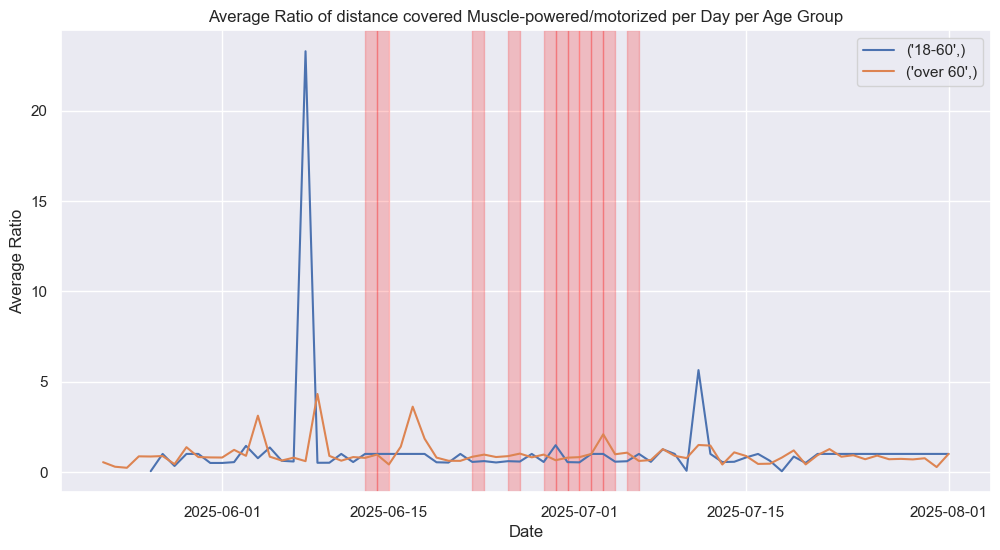

In [236]:
# Plot the average distance per day per group in two different plots. One for the motorized distances and one for the muscle-powered distances.
import matplotlib.pyplot as plt

start = pd.to_datetime('2025-05-20')
end = pd.to_datetime('2025-08-01')

what = 'muscle_motor_ratio' #'dist_diff'

# Highlight heatwave days
d_hw = days_with_heatwave[(days_with_heatwave['date'] >= start.date()) & (days_with_heatwave['date'] <= end.date())]

# Compute mean of ratio
df_ratio_mean = df_ratio.groupby(['age_group', 'start_time'])[what].mean().reset_index()
df_ratio_mean = df_ratio_mean[(df_ratio_mean['start_time'] >= start) & (df_ratio_mean['start_time'] <= end)]

# Distances ratio
plt.figure(figsize=(12, 6))
for key, grp in df_ratio_mean.groupby(['age_group']):
    plt.plot(grp['start_time'], grp[what], label=key)

for _, row in d_hw.iterrows():
    plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='red', alpha=0.2)

plt.title('Average Ratio of distance covered Muscle-powered/motorized per Day per Age Group')
plt.xlabel('Date')
plt.ylabel('Average Ratio')
plt.legend()
plt.show()

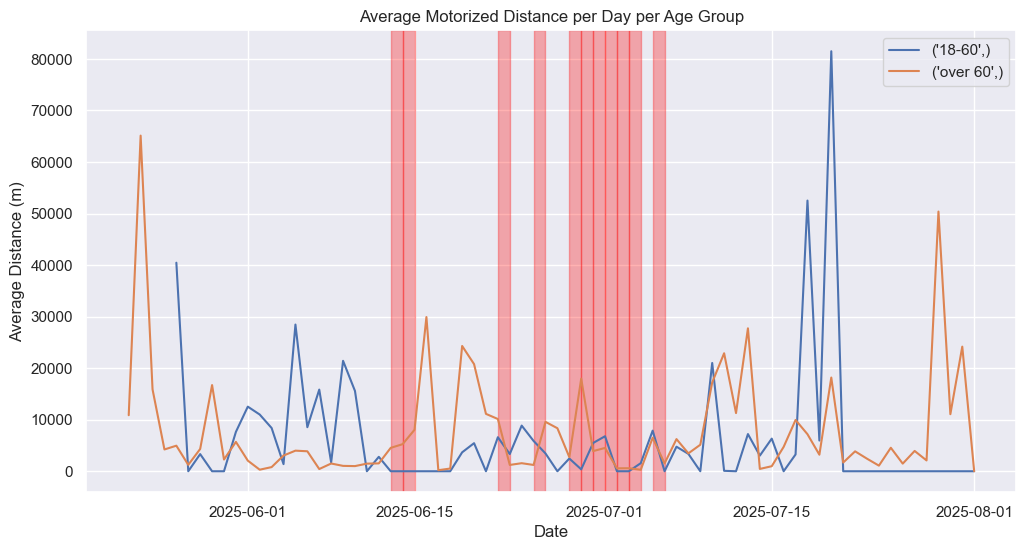

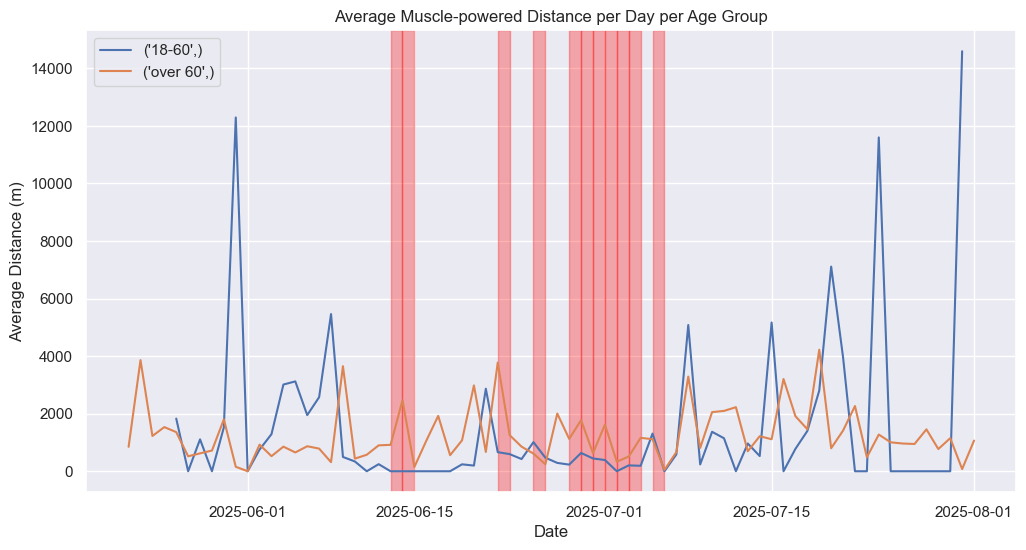

In [237]:
# Plot the average distance per day per group in two different plots. One for the motorized distances and one for the muscle-powered distances.
import matplotlib.pyplot as plt

start = pd.to_datetime('2025-05-20')
end = pd.to_datetime('2025-08-01')

what = 'distance(m)' #'dist_diff'

# Highlight heatwave days
d_hw = days_with_heatwave[(days_with_heatwave['date'] >= start.date()) & (days_with_heatwave['date'] <= end.date())]

# Motorized distances
df_motorized = df_age_grouped[df_age_grouped['mot_type'] == 'motor']
df_motorized = df_motorized[(df_motorized['start_time'] >= start) & (df_motorized['start_time'] <= end)]
# Add difference wrt to the mean per day
df_motorized["dist_diff"] = df_motorized["distance(m)"] - df_motorized["distance(m)"].mean()
plt.figure(figsize=(12, 6))
for key, grp in df_motorized.groupby(['age_group']):
    plt.plot(grp['start_time'], grp[what], label=key)

for _, row in d_hw.iterrows():
    plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='red', alpha=0.3)

plt.title('Average Motorized Distance per Day per Age Group')
plt.xlabel('Date')
plt.ylabel('Average Distance (m)')
plt.legend()
plt.show()

# Muscle-powered distances
df_muscle = df_age_grouped[df_age_grouped['mot_type'] == 'muscle']
df_muscle = df_muscle[(df_muscle['start_time'] >= start) & (df_muscle['start_time'] <= end)]
df_muscle["dist_diff"] = df_muscle["distance(m)"] - df_muscle["distance(m)"].mean()
plt.figure(figsize=(12, 6))

for key, grp in df_muscle.groupby(['age_group']):
    plt.plot(grp['start_time'], grp[what], label=key)


for _, row in d_hw.iterrows():
    plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='red', alpha=0.3)

plt.title('Average Muscle-powered Distance per Day per Age Group')
plt.xlabel('Date')
plt.ylabel('Average Distance (m)')
plt.legend()
plt.show()

In [ ]:
# Per each person per day, compute the ratio between motorized and muscle-powered distances


In [146]:
df_all_modes_age

,start_time,heatwave,participant_id,distance(m),gender,yob,age_group
0,2025-05-22,False,4T11G3A,11784,F,1959,over 60
1,2025-05-23,False,4T11G3A,237976,F,1959,over 60
2,2025-05-24,False,4T11G3A,49272,F,1959,over 60
3,2025-05-25,False,4T11G3A,34049,F,1959,over 60
4,2025-05-26,False,4T11G3A,0,F,1959,over 60
...,...,...,...,...,...,...,...
519,2025-07-16,False,1G2T1K,0,F,1976,18-60
520,2025-07-17,False,1G2T1K,0,F,1976,18-60
521,2025-07-18,False,1G2T1K,212734,F,1976,18-60
522,2025-07-19,False,1G2T1K,29448,F,1976,18-60


In [147]:
# Average distance per age group per day
df_avg_distance_age = df_all_modes_age.groupby(['age_group', 'start_time']).agg({'distance(m)': 'mean'}).reset_index()

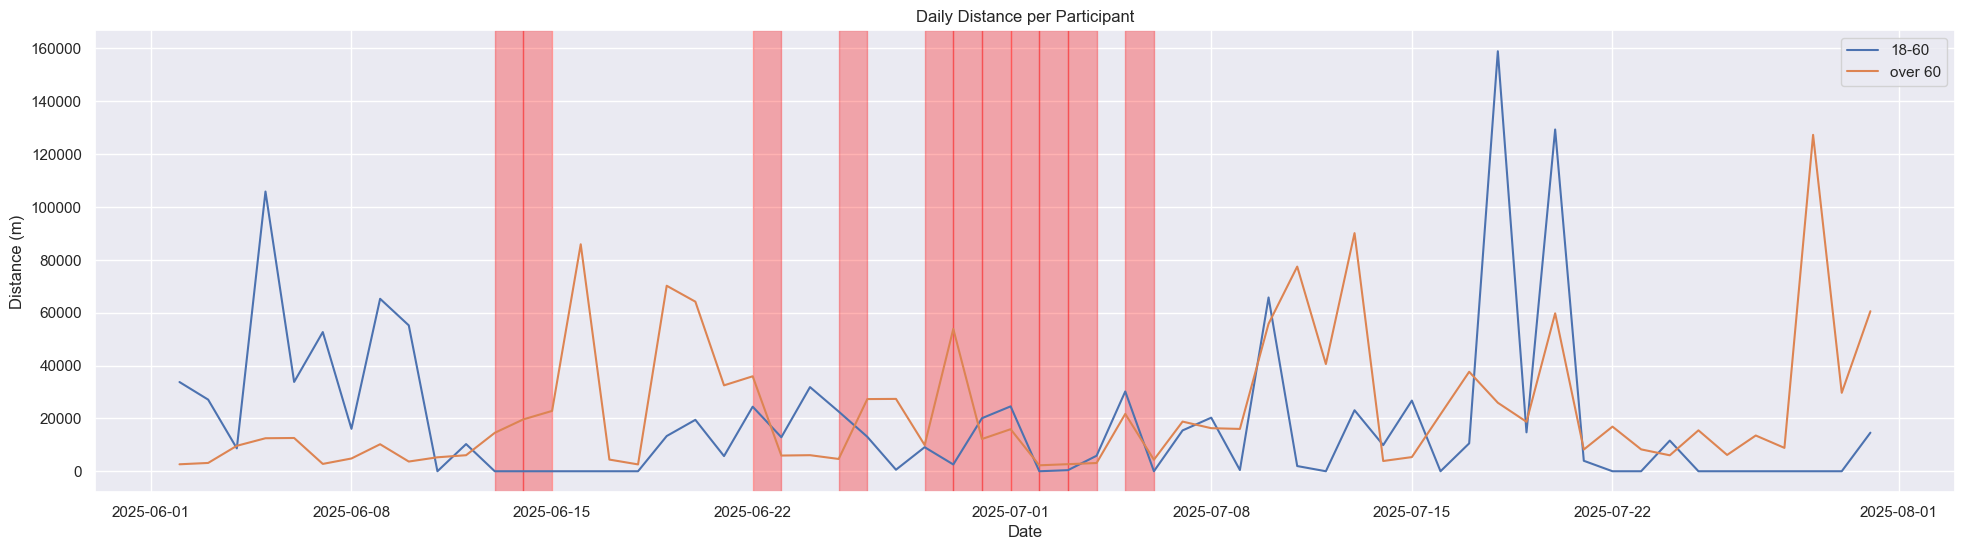

In [153]:
# I want to plot the distance per day per participant, and color in a different color the days during a heatwave
import matplotlib.pyplot as plt

sns.set_theme()
plt.figure(figsize=(24, 6))

# Plot the distance per day per participant
for participant_id, group in df_avg_distance_age.groupby('age_group'):
    group = group[(group['start_time'] > pd.Timestamp('2025-06-01')) & (group['start_time'] < pd.Timestamp('2025-08-01'))]
    plt.plot(group['start_time'], group['distance(m)'], label=participant_id)

# Highlight heatwave days
d_hw = days_with_heatwave[(days_with_heatwave['date'] > pd.Timestamp('2025-06-01').date()) & (days_with_heatwave['date'] < pd.Timestamp('2025-08-01').date())]
for _, row in d_hw.iterrows():
    plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='red', alpha=0.3)

plt.title('Daily Distance per Participant')
plt.xlabel('Date')
plt.ylabel('Distance (m)')
plt.legend()
plt.show()

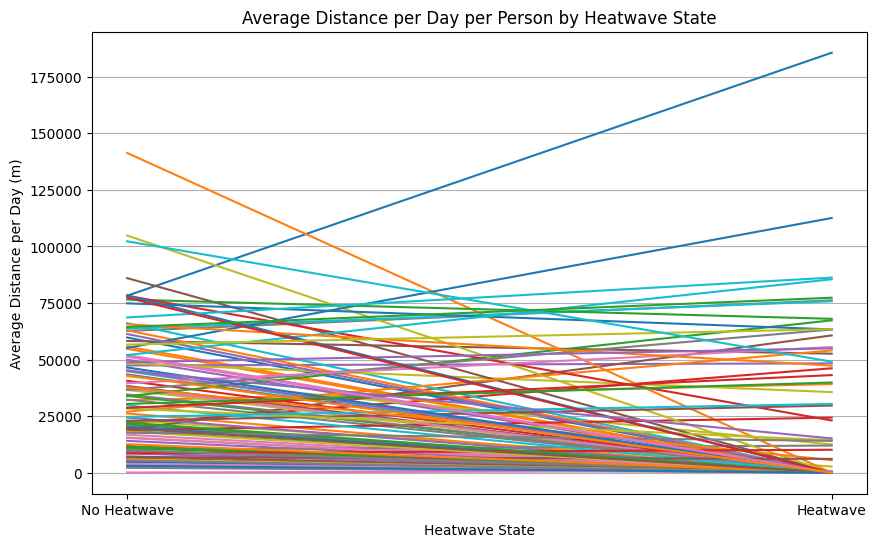

In [111]:
# Plot on a graph the average distance per day per person, depending on the heatwave state
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Line plot: x = heatwave (0 or 1), y = average distance
for pid, group in df_grouped.groupby('participant_id'):
    plt.plot(group['heatwave'], group['distance(m)'], label=f'Participant {pid}')

plt.xlabel('Heatwave State')
plt.ylabel('Average Distance per Day (m)')
plt.title('Average Distance per Day per Person by Heatwave State')
plt.xticks([0, 1], ['No Heatwave', 'Heatwave'])
plt.grid(axis='y')
plt.show()

In [112]:
df_noplane

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving,geometry,start_time_precise,end_time_precise,duration,heatwave
13,219935XE1,2024-08-28,2024-08-28,u0m70d,u0m709,546,BICYCLE,ON_BICYCLE,3,False,None,2024-08-28 06:47:10+00:00,2024-08-28 06:49:10+00:00,120.0,False
9,219935XE1,2024-08-28,2024-08-28,u0m709,u0m70d,551,BICYCLE,ON_BICYCLE,3,False,None,2024-08-28 06:47:44+00:00,2024-08-28 06:51:20+00:00,216.0,False
14,219935XE1,2024-08-28,2024-08-28,u0m709,u0m714,2884,TRAIN,TRAIN,20,False,None,2024-08-28 06:51:04+00:00,2024-08-28 06:54:44+00:00,220.0,False
15,219935XE1,2024-08-28,2024-08-28,u0m714,u0m714,665,BICYCLE,ON_BICYCLE,3,False,None,2024-08-28 06:55:31+00:00,2024-08-28 07:06:15+00:00,644.0,False
8,219935XE1,2024-08-28,2024-08-28,u0m714,u0m714,497,WALKING,WALKING,0,False,None,2024-08-28 06:55:45+00:00,2024-08-28 07:06:08+00:00,623.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28484,4L5S1E,2025-08-18,2025-08-18,u0m468,u0m44z,607,WALKING,WALKING,0,True,None,2025-08-18 07:35:31+00:00,2025-08-18 07:44:32+00:00,541.0,False
28487,4L5S1E,2025-08-18,2025-08-18,u0m44z,u0m44y,676,BICYCLE,ON_BICYCLE,3,True,None,2025-08-18 07:44:33+00:00,2025-08-18 07:51:33+00:00,420.0,False
28490,4Z11FXF,2025-08-18,2025-08-18,u0qnnq,u0qnnq,301,WALKING,WALKING,0,False,None,2025-08-18 08:01:21+00:00,2025-08-18 08:04:22+00:00,181.0,False
28491,4Z11FXF,2025-08-18,2025-08-18,u0qnnq,u0qnnw,649,BUS,ELECTRIC_BUS,41,False,None,2025-08-18 08:04:38+00:00,2025-08-18 08:06:58+00:00,140.0,False


In [113]:
# Compute average distance per day per person, depending on heatwave state
df_grouped_1 = df_noplane.groupby(['start_time', 'participant_id', 'heatwave', 'mean_of_transport'])['distance(m)'].sum().reset_index()

# Sort dataframe by start_time
df_grouped_1 = df_grouped_1.sort_values(by='start_time')

df_completed = pd.DataFrame()

# Complete for each participant and mean_of_transport
for (participant, mot) in df_grouped_1[['participant_id', 'mean_of_transport']].drop_duplicates().values:
    p_hw_df = df_grouped_1[(df_grouped_1['participant_id'] == participant) & (df_grouped_1['mean_of_transport'] == mot)].copy()

    # Create a complete date range from the first to the last date in the participant's data
    date_range = pd.date_range(start=p_hw_df['start_time'].min(), end=p_hw_df['start_time'].max())

    # Set start_time as index and reindex to fill missing dates
    p_hw_df = p_hw_df.set_index('start_time').reindex(date_range, fill_value=0).reset_index()
    p_hw_df.rename(columns={'index': 'start_time'}, inplace=True)
    p_hw_df['participant_id'] = participant
    p_hw_df['mean_of_transport'] = mot

    # Recompute the heatwave state for the complete date range
    p_hw_df['heatwave'] = p_hw_df['start_time'].isin(heatwave_dates)

    # Append the completed data to the main dataframe
    df_completed = pd.concat([df_completed, p_hw_df])

df_grouped_1 = df_completed

# Compute average distance per day per person, depending on heatwave state
df_grouped_1 = df_grouped_1.groupby(['participant_id', 'heatwave', 'mean_of_transport'])['distance(m)'].mean().reset_index()

# Get all unique participants and heatwave states
means_of_transport = df_grouped_1['mean_of_transport'].unique()
participants = df_grouped_1['participant_id'].unique()
heatwave_states = [True, False]

# Create full index of all combinations
full_index = pd.MultiIndex.from_product([participants, heatwave_states, means_of_transport], names=['participant_id', 'heatwave', 'mean_of_transport'])

# Group and compute average distance
df_grouped_1 = df_grouped_1.groupby(['participant_id', 'heatwave', 'mean_of_transport'])['distance(m)'].mean().reindex(full_index, fill_value=0).reset_index()

df_grouped_1

,participant_id,heatwave,mean_of_transport,distance(m)
0,0H2T3S,True,BUS,0.000000
1,0H2T3S,True,TRAIN,0.000000
2,0H2T3S,True,WALKING,0.000000
3,0H2T3S,True,BICYCLE,0.000000
4,0H2T3S,True,BOAT,0.000000
...,...,...,...,...
1643,9W8SXR,False,BICYCLE,1637.888889
1644,9W8SXR,False,BOAT,0.000000
1645,9W8SXR,False,CAR,8981.442623
1646,9W8SXR,False,TRAM,0.000000


/var/folders/hc/bxt7k06n5532f1ws84vbg7180000gn/T/ipykernel_21118/4014732606.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


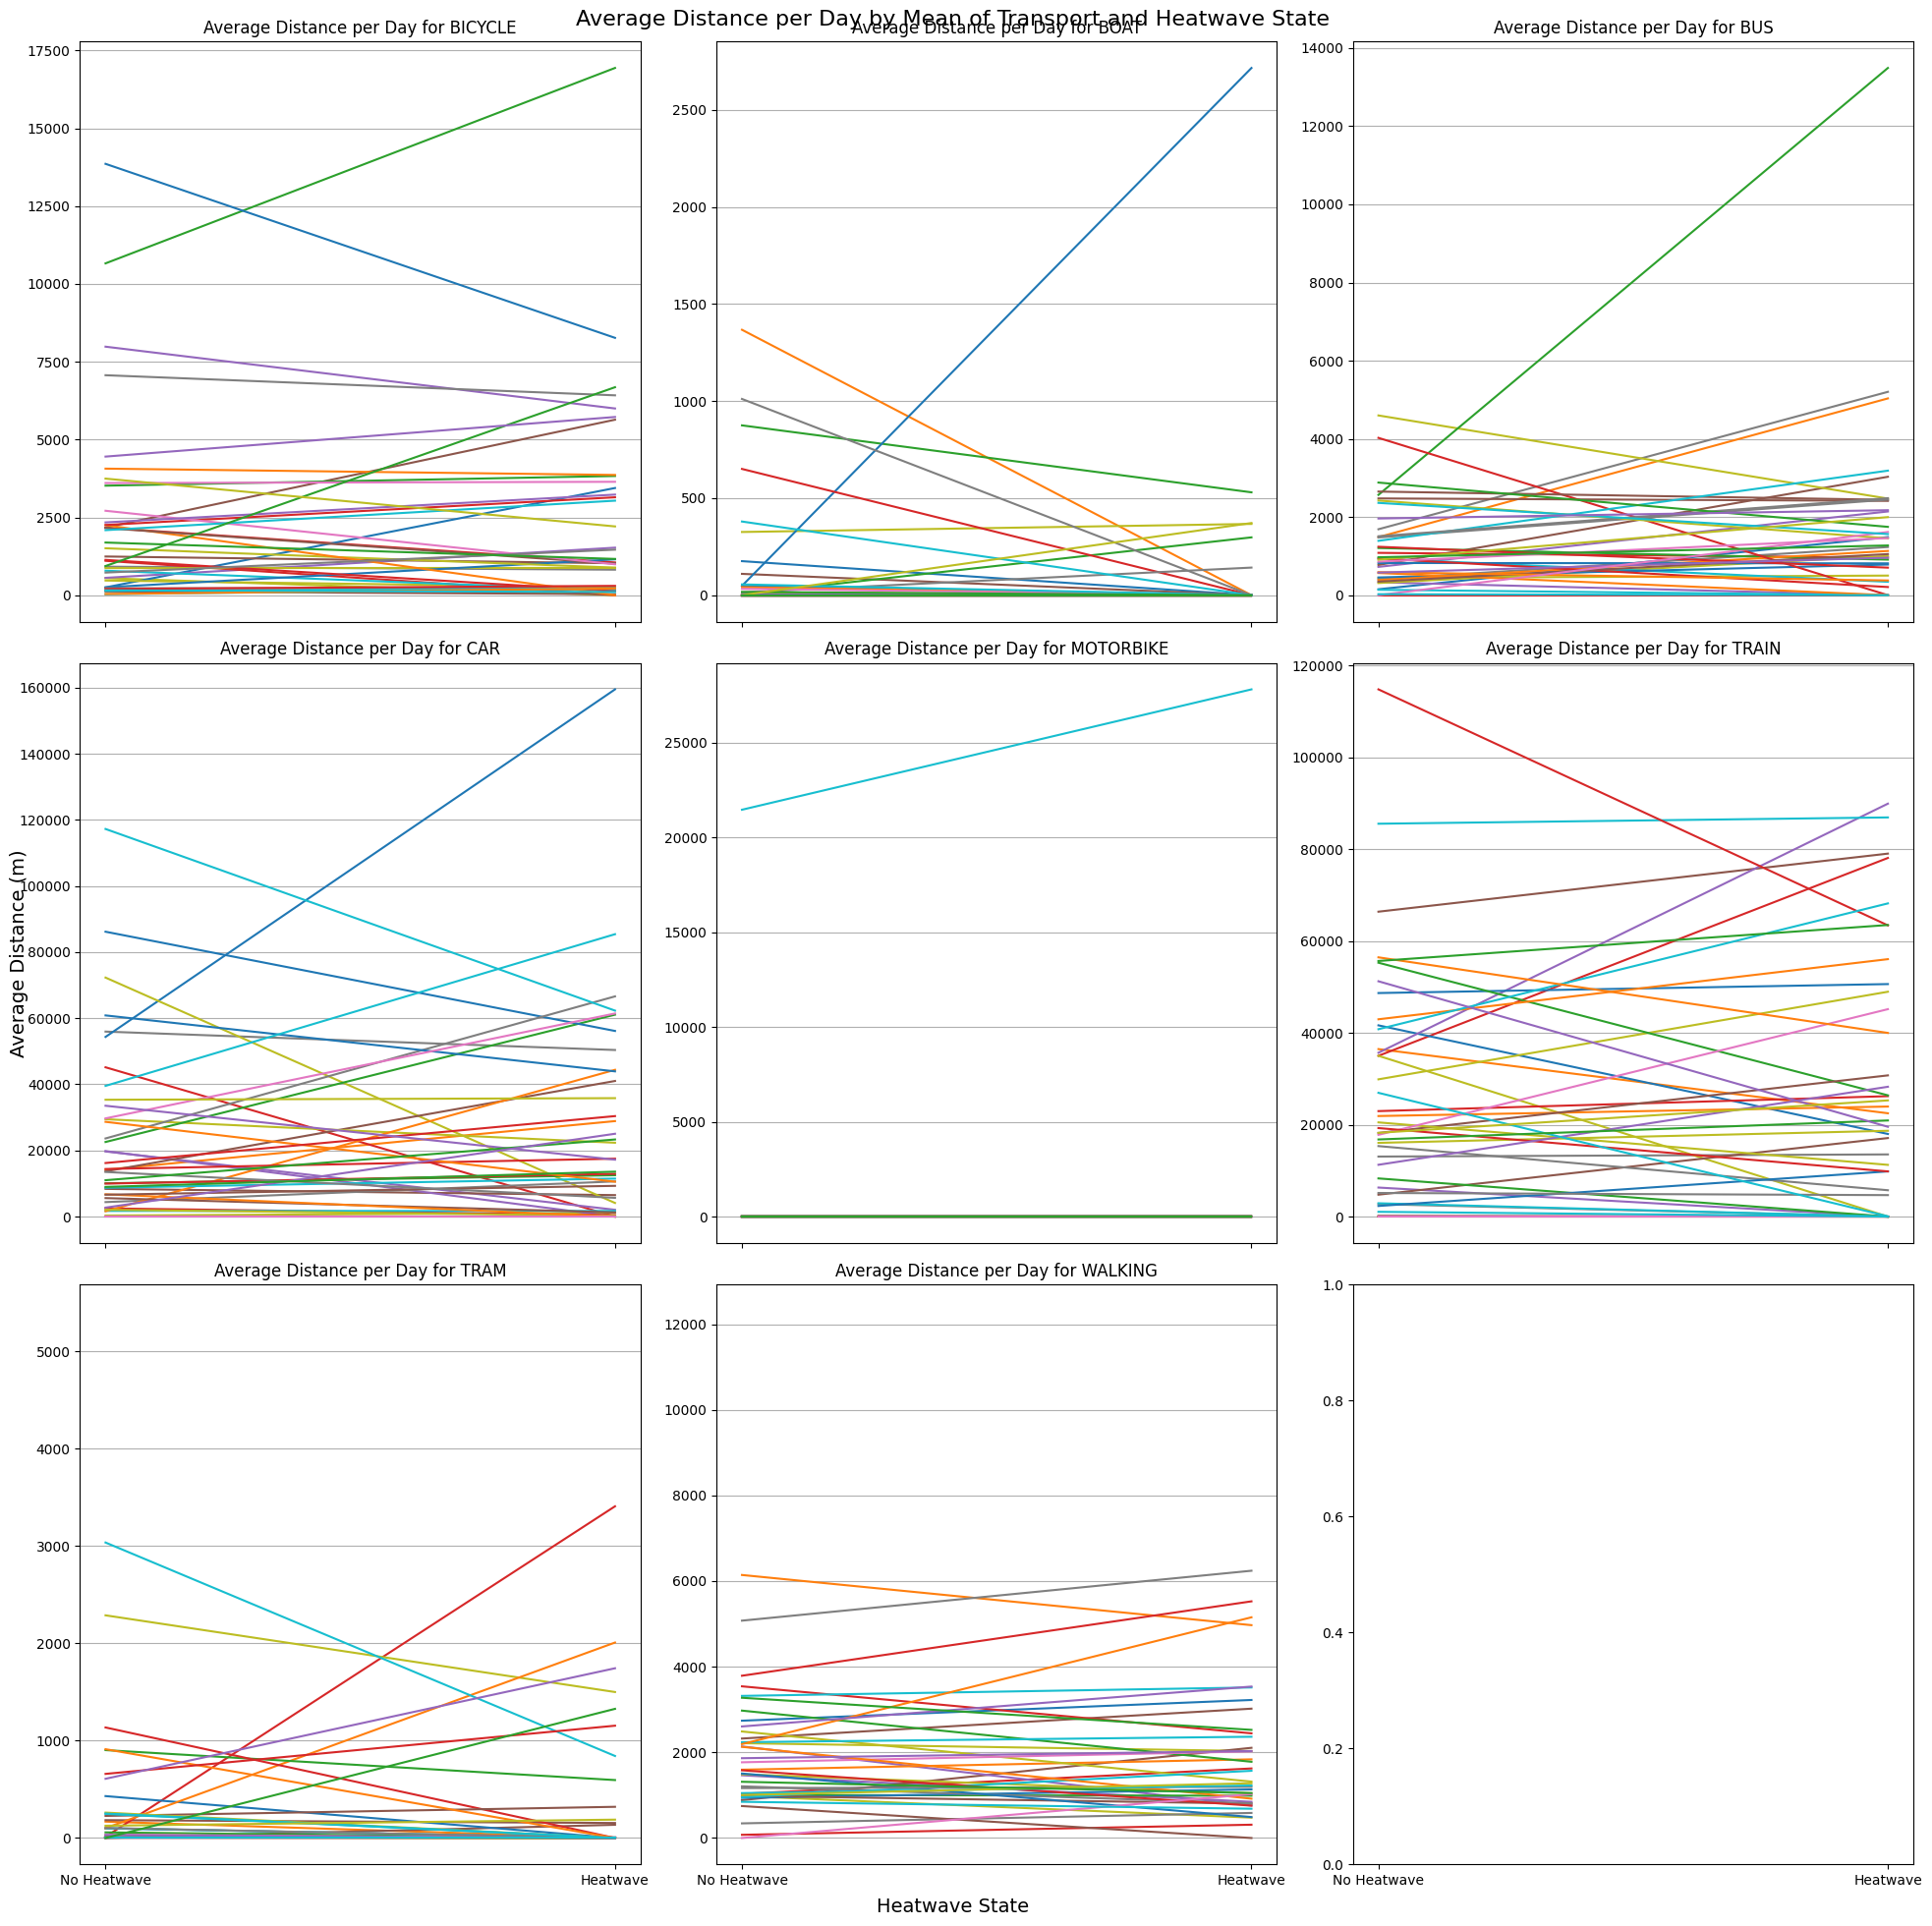

In [114]:
# Compute the average distance per day for all participants, depending on the used mode of transport and the heatwave state
# Compute average distance per day per person, depending on heatwave state
df_grouped_1 = df_noplane.groupby(['start_time', 'participant_id', 'heatwave', 'mean_of_transport'])['distance(m)'].sum().reset_index()

# Complete data by adding 0 for the start_time, heatwave and mean_of_transport where the user did not have any movement
df_grouped_1 = df_grouped_1.set_index(['start_time', 'participant_id', 'heatwave', 'mean_of_transport']).unstack(fill_value=0).stack().reset_index()

# Compute average distance per day per person, depending on heatwave state. We want to have 0 for the days where the user did not use the mean of transport.
df_avg_distance = df_grouped_1.groupby(['participant_id', 'heatwave', 'mean_of_transport'])['distance(m)'].mean().reset_index()

# Plot the average distance per day for all participants, as a function of the heatwave state. One plot per mean of transport
unique_modes = df_avg_distance['mean_of_transport'].unique()
n_modes = len(unique_modes)
ncols = 3
nrows = (n_modes + ncols - 1) // ncols  # Ensure enough rows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
axes = axes.flatten()  # Flatten for easy indexing

fig.suptitle('Average Distance per Day by Mean of Transport and Heatwave State', fontsize=16)
fig.supxlabel('Heatwave State', fontsize=14)
fig.supylabel('Average Distance (m)', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, transport_mode in enumerate(unique_modes):
    for pid, group in df_avg_distance[df_avg_distance['mean_of_transport'] == transport_mode].groupby('participant_id'):
        # Plot each participant's data
        axes[i].plot(group['heatwave'], group['distance(m)'], label=f'Participant {pid}')
    axes[i].set_title(f'Average Distance per Day for {transport_mode}')
    axes[i].set_xticks([0, 1], ['No Heatwave', 'Heatwave'])
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

In [115]:
# Count number of unique participant ids
num_unique_participants = df_noplane['participant_id'].nunique()
print(f"Number of unique participants: {num_unique_participants}")

Number of unique participants: 103


In [116]:
# Same thing, but splitting data by start_time in groups of 00-05, 05-07, 07-09, 09-11, 11-13, 13-15, 15-17, 17-19, 19-21, 21-00
df_noplane['start_time_group'] = pd.cut(df_noplane['start_time_precise'].dt.hour,
                                         bins=[-1, 4, 6, 8, 10, 12, 14, 16, 18, 20, 23],
                                         labels=['00-05', '05-07', '07-09', '09-11', '11-13', '13-15', '15-17', '17-19', '19-21', '21-00'],
                                         right=True)

# Compute average distance per day per person, depending on heatwave state and start_time_group
df_grouped_time = df_noplane.groupby(['start_time', 'start_time_group', 'participant_id', 'heatwave'])['distance(m)'].sum().reset_index()
# Compute average distance per day per person, depending on heatwave state and start_time_group
df_grouped_time = df_grouped_time.groupby(['participant_id', 'start_time_group', 'heatwave'])['distance(m)'].mean().reset_index()
df_grouped_time

,participant_id,start_time_group,heatwave,distance(m)
0,0H2T3S,00-05,False,0.000000
1,0H2T3S,00-05,True,0.000000
2,0H2T3S,05-07,False,0.000000
3,0H2T3S,05-07,True,0.000000
4,0H2T3S,07-09,False,0.000000
...,...,...,...,...
2055,9W8SXR,17-19,True,293.721910
2056,9W8SXR,19-21,False,55.011236
2057,9W8SXR,19-21,True,312.879213
2058,9W8SXR,21-00,False,1.780899


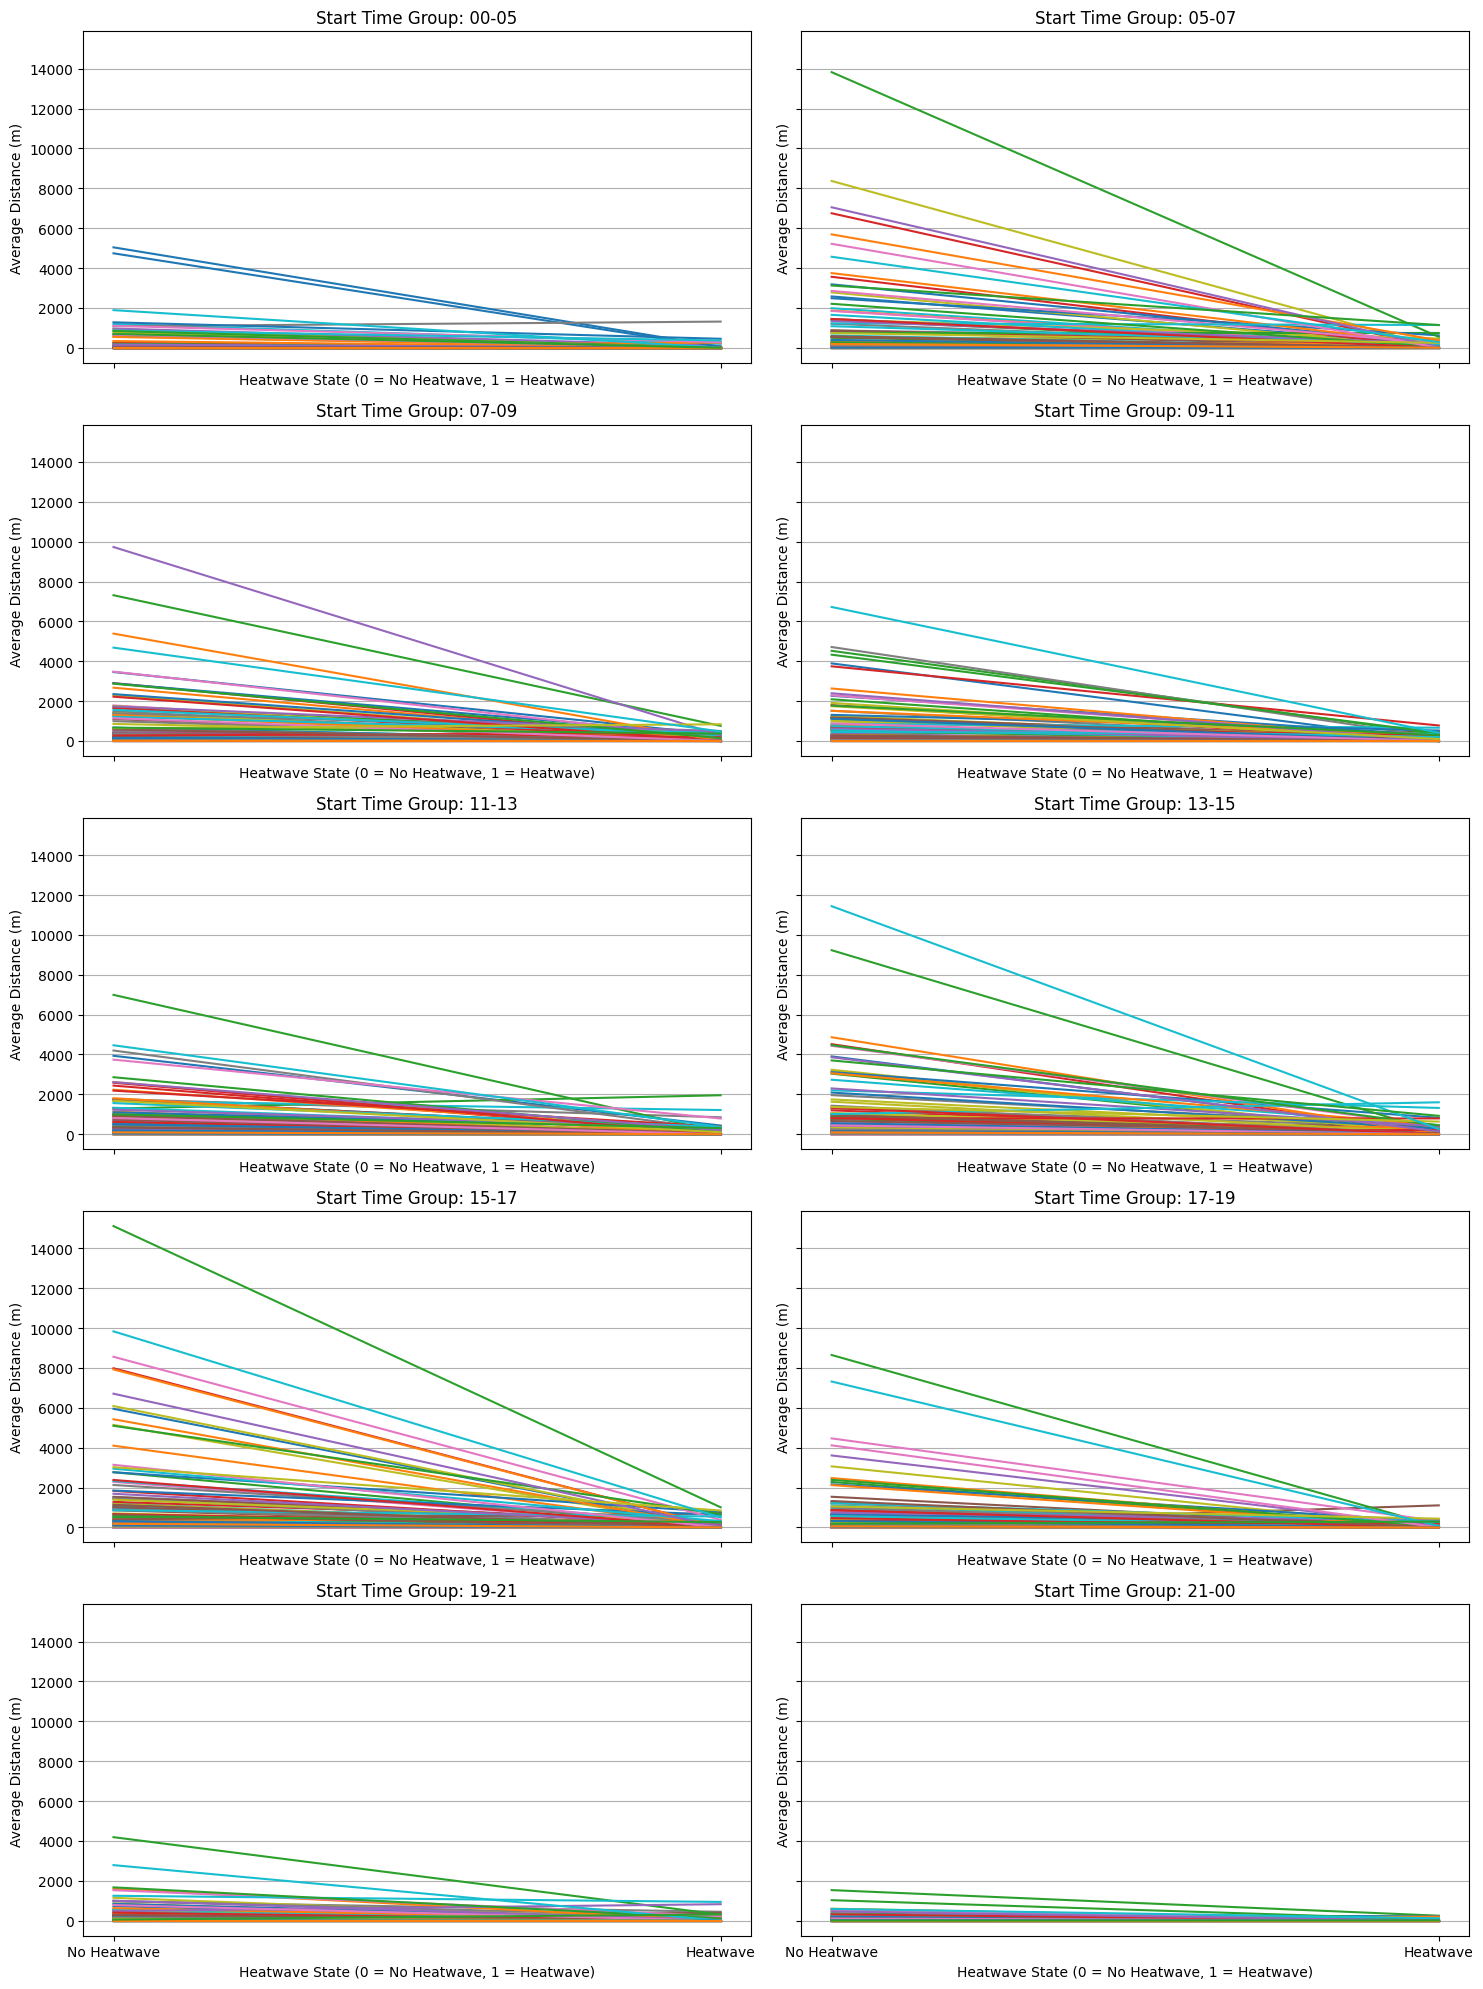

In [117]:
# Create different subplots for all the start_time_group
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.flatten()
for i, group in enumerate(df_grouped_time.groupby('start_time_group')):
    start_time_group, data = group
    for pid, group_data in data.groupby('participant_id'):
        axs[i].plot(group_data['heatwave'], group_data['distance(m)'], label=f'Participant {pid}')
    
    axs[i].set_title(f'Start Time Group: {start_time_group}')
    axs[i].set_xlabel('Heatwave State (0 = No Heatwave, 1 = Heatwave)')
    axs[i].set_ylabel('Average Distance (m)')
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['No Heatwave', 'Heatwave'])
    axs[i].grid(axis='y')
plt.tight_layout()
plt.show()

In [118]:
# Split data in two dataframes, one for longer trips (train, car, electric_car, hybrid_car) and one for shorter trips (walking, bicycle, bus, tram)
df_long_trips = df_noplane[df_noplane['mean_of_transport'].isin(['TRAIN', 'CAR', 'ELECTRIC_CAR', 'HYBRID_CAR'])].copy()
# All the rest are shorter trips
df_short_trips = df_noplane[~df_noplane['mean_of_transport'].isin(['TRAIN', 'CAR', 'ELECTRIC_CAR', 'HYBRID_CAR'])].copy()

#### TODO: We need to add 0 for each day where the person did not move with that mode of transport

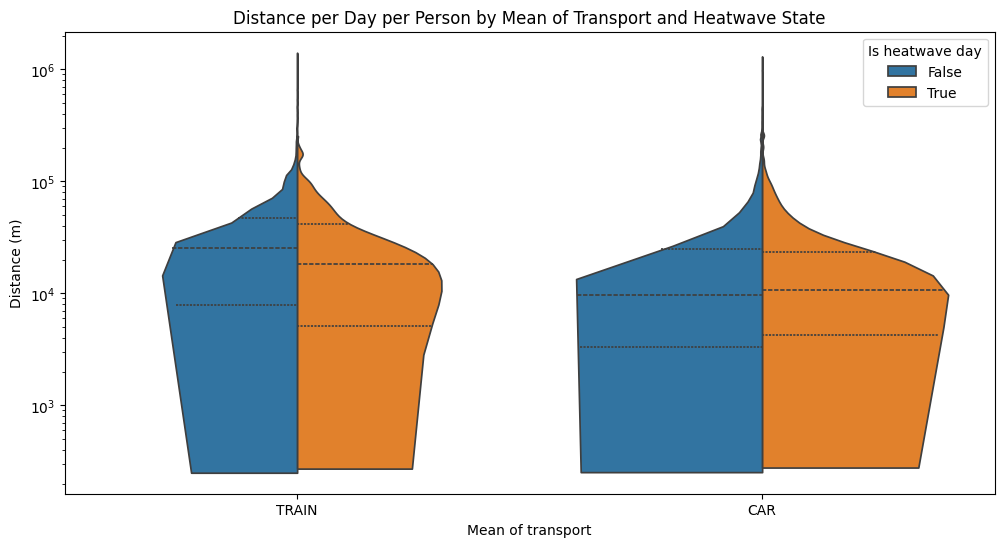

In [119]:
# Violin plot of distances per day per person, depending on heatwave state and mean of transport
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.violinplot(x='mean_of_transport', y='distance(m)', hue='heatwave', data=df_long_trips, split=True, inner='quartile', cut=0)
plt.xlabel('Mean of transport')
plt.ylabel('Distance (m)')
plt.title('Distance per Day per Person by Mean of Transport and Heatwave State')
plt.legend(title='Is heatwave day', loc='upper right')
plt.yscale('log')  # Use logarithmic scale for better visibility of shorter trips
plt.show()

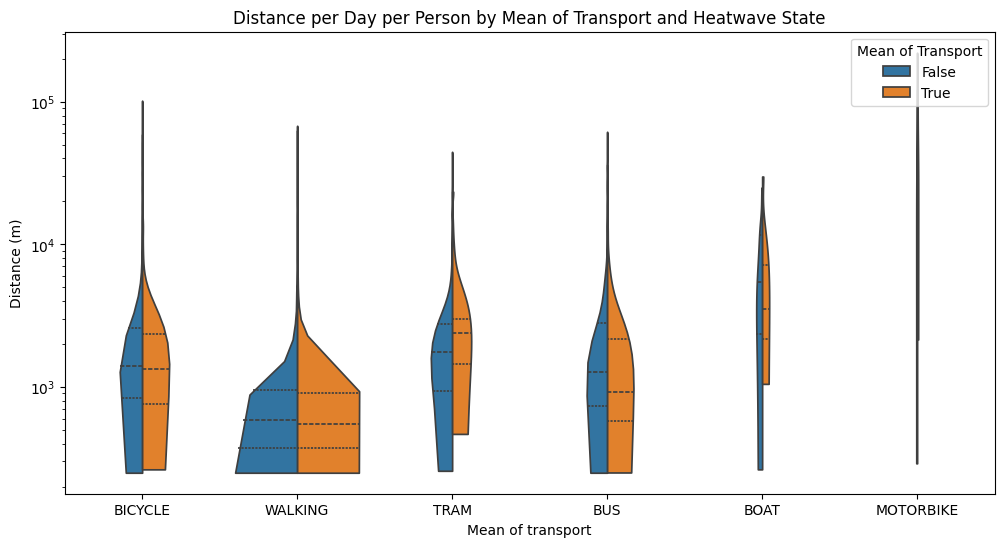

In [120]:
# Violin plot of distances per day per person, depending on heatwave state and mean of transport
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.violinplot(x='mean_of_transport', y='distance(m)', hue='heatwave', data=df_short_trips, split=True, inner='quartile', cut=0)
plt.xlabel('Mean of transport')
plt.ylabel('Distance (m)')
plt.title('Distance per Day per Person by Mean of Transport and Heatwave State')
plt.legend(title='Mean of Transport', loc='upper right')
plt.yscale('log')  # Use logarithmic scale for better visibility of shorter trips
plt.show()

## Create a visualization of the covered routes

In [22]:
## Get a coordinate from a geohash, adding a small random offset to avoid overlapping
def geohash_to_coordinate(geohash):
    try:
        lat, lon = geolib.decode(geohash)
        #lat = float(lat) + 0.00000001#(random.random() - 0.5) * 0.00000001
        #lon = float(lon) + 0.00000001#(random.random() - 0.5) * 0.00000001
        return [float(lat), float(lon)]
    except:
        return [float(0.0), float(0.0)]

In [23]:
## Draw a path from start_geohash to end_geohash on a folium map
def draw_path(start_geohash, end_geohash, mean_of_transport, map, weight=1, tooltip=None):
    ## Give a different color to each mean of transport
    colors = {
        'WALKING': '#7FC97F',
        'ON_BICYCLE': '#BDAED4',
        'ELECTRIC_BIKE': '#BDAED4',
        'SCOOTER': '#BDAED4',
        'TRAIN': '#FDBF85',
        'BUS': '#FFFF99',
        'ELECTRIC_BUS': '#FFFF99',
        'CAR': '#386CB0',
        'ELECTRIC_CAR': '#386CB0',
        'HYBRID_CAR': '#386CB0',
        'TRAM': '#F0027F',
        'PLANE': '#BE5B17',
        'BOAT': '#BE5B17',
        'BOAT_NO_ENGINE': '#BE5B17',
        'DETECTION_ERROR': '#000000',
        'COACH': '#FFFF99',
    }

    try:
        start_coord = geohash_to_coordinate(start_geohash)
        end_coord = geohash_to_coordinate(end_geohash)

        # Add a small offset to avoid overlapping
        start_coord[0] += (random.random() - 0.5) * 0.001
        start_coord[1] += (random.random() - 0.5) * 0.001
        end_coord[0] += (random.random() - 0.5) * 0.001
        end_coord[1] += (random.random() - 0.5) * 0.001

        #arc_drawer.draw_arc(map, start_coord[0], start_coord[1], end_coord[0], end_coord[1], color=colors[mean_of_transport], weight = weight)

        folium.PolyLine(locations=[start_coord, end_coord], color=colors[mean_of_transport], weight=weight, tooltip=tooltip).add_to(map)
    except Exception as e:
        print(e)
        print(start_geohash, end_geohash)


In [21]:
## Create the actual folium map
m = folium.Map(location=[46.9446011, 7.4143311], zoom_start=6, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')

# Count the number of movements with the same combination of start_geohash and end_geohash (or vice-versa)
df['start_end_geohash'] = df['start_geohash'] + df['end_geohash']
df['end_start_geohash'] = df['end_geohash'] + df['start_geohash']

## Get the number of movements with the same combination of start_geohash and end_geohash (or vice-versa)
start_end = df['start_end_geohash'].value_counts()
end_start = df['end_start_geohash'].value_counts()

## Create a list with the sum of the two previous lists, when the index is the same
combined = {}

for index, row in start_end.items():
    if index in end_start:
        combined[index] = row + end_start[index]
    else:
        combined[index] = row

for index, row in end_start.items():
    if index not in combined:
        combined[index] = row

## Convert combined to series
combined = pd.Series(combined)

# Log scaling
combined = combined.apply(lambda x: math.log(x) + 1)

# Draw path for each movement in start_end
for index, row in combined.items():
    start_geohash = index[0:len(index)//2]
    end_geohash = index[len(index)//2:len(index)] 

    try:
        mean_of_transport = df.loc[(df['start_geohash'] == start_geohash) & (df['end_geohash'] == end_geohash), 'mean_of_transport'].iloc[0]
    except:
        mean_of_transport = df.loc[(df['end_geohash'] == start_geohash) & (df['start_geohash'] == end_geohash), 'mean_of_transport'].iloc[0]

    draw_path(start_geohash, end_geohash, mean_of_transport, m, weight = row/max(combined)*7)

## Draw a path for each movement
#for index, row in df.iterrows():
#    draw_path(row['start_geohash'], row['end_geohash'], row['mean_of_transport'], m)

## Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

## Save the map as an html file
m.save('maps/paths_map.html')


## Create a heatmap of the locations visited

In [22]:
## Extract from df a list of all start_geohashes and end_geohashes
geohashes = list(df['start_geohash']) + list(df['end_geohash'])
len(geohashes)

19848

In [23]:
# If we want, we can remove some characters from the end of each geohash to reduce the precision
geohashes = [geohash[:-1] for geohash in geohashes]

In [24]:
# Convert the list of geohashes to a dataframe
geohashes_df = gpd.GeoDataFrame(geohashes, columns=['geohash'])

## Convert the list of geohashes to a geoJSON object


In [25]:
## Convert geohashes to a heatmap in geojson format
def geohashes_to_heatmap(df):
    # Get the distinct geohashes and their counts from the dataframe
    geohashes = df['geohash'].value_counts()

    # Get the maximum count of any geohash
    max_count = math.log(geohashes.max())

    # Convert the geohashes to a list of lists, each containing the geohash and its count
    geohashes = [[geohash, count] for geohash, count in zip(geohashes.index, geohashes)]
    
    # Create a color scale for the heatmap
    color_scale = linear.RdYlBu_10.scale(1, max_count)

    # Convert geohashes to features for geoJSON
    features = []

    for geohash in geohashes:
        # Get the bounds of the geohash
        bounds = geolib.bounds(geohash[0])
        color = color_scale(math.log(geohash[1]))

        # Create a feature for the geohash
        features.append({
            "type": "Feature",
            "properties": {
                "id": geohash[0],
                "fillColor": color,
                "fillOpacity": 0.6,
                "stroke": False
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bounds.sw.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.sw.lat]
                ]]
            },
        })

    # Convert the geohashes to a heatmap in geojson format
    return {
        "type" : "FeatureCollection",
        "features": features
    }

In [26]:
# Convert the geohashes to a heatmap in geojson format
heatmap = geohashes_to_heatmap(geohashes_df)

# Save GeoJSON with double quotes
with open('results/heatmap.geojson', 'w') as f:
    json.dump(heatmap, f)

In [27]:
# Visualize as a heatmap using Folium
# Create a folium map centered at an initial location
def create_map(geojson, mapname, legend=None):
    m = folium.Map(location=[46.9446011, 7.4143311],zoom_start=6, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')

    # Define a style function to set the color of the polygon
    def style_function(feature):
        return {
            'fillColor': feature["properties"]["fillColor"],  # Change this to the desired color
            'stroke': feature["properties"]["stroke"],
            'fillOpacity': feature["properties"]["fillOpacity"],
        }

    # Add GeoJSON data to the map with the style function
    folium.GeoJson(
        geojson,
        name='Polygon Layer',
        style_function=style_function,
    ).add_to(m)

    # Add Layer Control to the map
    folium.LayerControl().add_to(m)

    if legend:
        m.get_root().html.add_child(folium.Element(legend))

    # Save or display the map
    m.save("maps/"+mapname)


In [28]:
create_map(heatmap, "heatmap.html")

In [29]:
!open -a Arc maps/heatmap.html

## Get the map of the most used vehicles

In [ ]:
## Get the list of geohashes with the corresponding mean of transport
geohashes = df[['start_geohash', 'mean_of_transport']].copy()
## Append the end_geohashes to the list of geohashes
geohashes = gpd.GeoDataFrame(pd.concat([geohashes, df[['end_geohash', 'mean_of_transport']]]))
## Merge start_geohashes and end_geohashes into a single column
geohashes['geohash'] = geohashes['start_geohash'].combine_first(geohashes['end_geohash'])
## Remove the start_geohashes and end_geohashes columns
geohashes = geohashes[['geohash', 'mean_of_transport']]

## Reduce precision of geohashes
geohashes['geohash'] = geohashes['geohash'] #.str[:-1]

geohashes

In [ ]:
## Find the mean of transport that occurs the more often for each geohash and keep only the first one (the most used)
geohashes_df = gpd.GeoDataFrame(geohashes, columns=['geohash', 'mean_of_transport'])
# Get the count of the mean of transport for each geohash
geohashes_df = geohashes_df.groupby(['geohash', 'mean_of_transport']).size().reset_index(name='counts')
# For each geohash, keep only the mean of transport that occurs the most often
geohashes_df = geohashes_df.sort_values('counts', ascending=False).drop_duplicates(['geohash'])
# Remove the counts column
#geohashes_df = geohashes_df[['geohash', 'mean_of_transport']]
geohashes_df

In [60]:
## Convert geohashes to a heatmap in geojson format
def heatmap_mot(df):
    ## Give a different color to each mean of transport
    colors = {
        'WALKING': '#7FC97F',
        'ON_BICYCLE': '#BDAED4',
        'ELECTRIC_BIKE': '#BDAED4',
        'SCOOTER': '#BDAED4',
        'TRAIN': '#FDBF85',
        'BUS': '#FFFF99',
        'ELECTRIC_BUS': '#FFFF99',
        'CAR': '#386CB0',
        'ELECTRIC_CAR': '#386CB0',
        'HYBRID_CAR': '#386CB0',
        'TRAM': '#F0027F',
        'PLANE': '#BE5B17',
        'BOAT': '#BE5B17'
    }

    # Convert geohashes to features for geoJSON
    features = []

    for geohash in df:
        # Get the bounds of the geohash
        bounds = geolib.bounds(geohash[0])
        color = colors[geohash[1]]

        # Create a feature for the geohash
        features.append({
            "type": "Feature",
            "properties": {
                "id": geohash[0],
                "fillColor": color,
                "fillOpacity": 0.8,
                "stroke": False
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bounds.sw.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.ne.lat],
                    [bounds.ne.lon, bounds.sw.lat],
                    [bounds.sw.lon, bounds.sw.lat]
                ]]
            },
        })

    # Convert the geohashes to a heatmap in geojson format
    return {
        "type" : "FeatureCollection",
        "features": features
    }

In [ ]:
# Convert the means of transport to a heatmap in geojson format
heatmap = heatmap_mot(geohashes_df.values)

# Save GeoJSON with double quotes
with open('results/heatmap_mot.geojson', 'w') as f:
    json.dump(heatmap, f)

In [97]:
create_map(heatmap, "heatmap_mot.html", legend_html)

In [98]:
!open -a Arc maps/heatmap_mot.html

## Get the map of the movements (start to end point)

In [27]:
# Now we should create a map with lines between the geohashes, with the color of the line corresponding to the mean of transport
# We should also create a legend for the map

## Create the actual folium map
m = folium.Map(location=[46.9446011, 7.4143311], zoom_start=8, tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=977802c5-9b2e-4fc3-9254-a9199d0d5d0c', attr='https://stadiamaps.com/')
# Draw a path for each movement
for index, row in df.iterrows():
    draw_path(row['start_geohash'], row['end_geohash'], row['mean_of_transport'], m, weight = 2, tooltip=row['participant_id'])


## Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

## Save the map as an html file
m.save('maps/paths_map_mot.html')

!open -a Arc maps/paths_map_mot.html

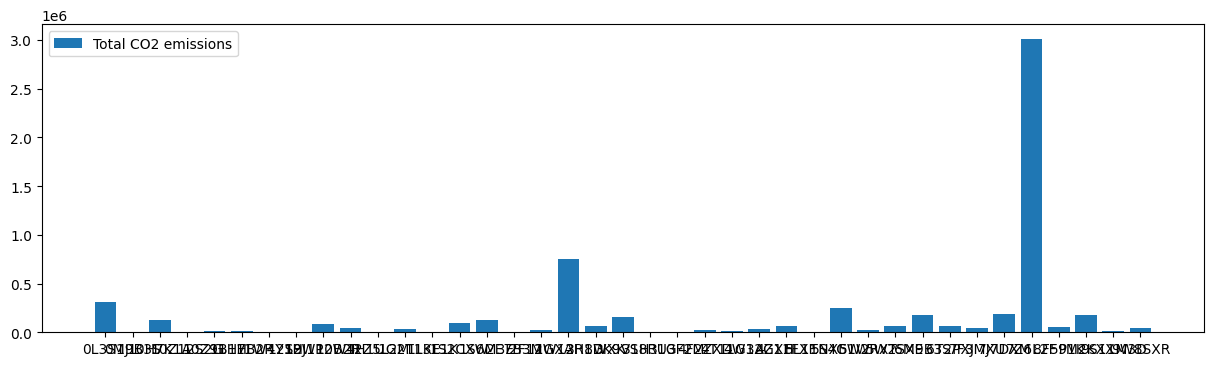

In [24]:
# Compute the total CO2 emissions for each person
df_co2 = df.groupby('participant_id')['gCO2'].sum()

# Plot the total CO2 emissions for each person in a bar plot, together with the average CO2 emissions per km in different bars
plt.figure(figsize=(15, 4))
plt.bar(df_co2.index, df_co2, label='Total CO2 emissions')
plt.legend()
plt.show()

/Users/colombmo/Documents/Lavoro/SWICE/Software/tests/OSMnx/osmnx/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


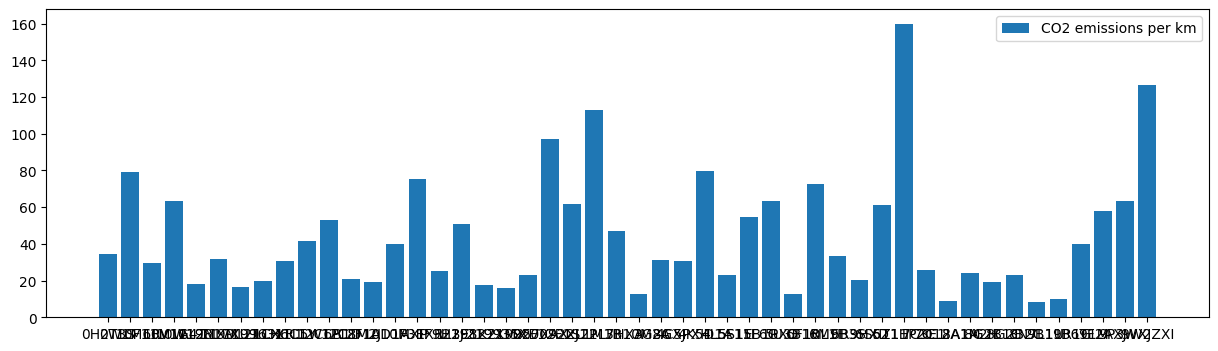

In [61]:
# Compute the emissions per km for each person
df['gCO2_per_km'] = df['gCO2'] / df['distance(m)'] * 1000
df['gCO2_per_km'] = df['gCO2_per_km'].replace([np.inf, -np.inf], np.nan)

# Plot the emissions per km for each person in a bar plot
df_co2_per_km = df.groupby('participant_id')['gCO2_per_km'].mean()
plt.figure(figsize=(15, 4))
plt.bar(df_co2_per_km.index, df_co2_per_km, label='CO2 emissions per km')
plt.legend()
plt.show()


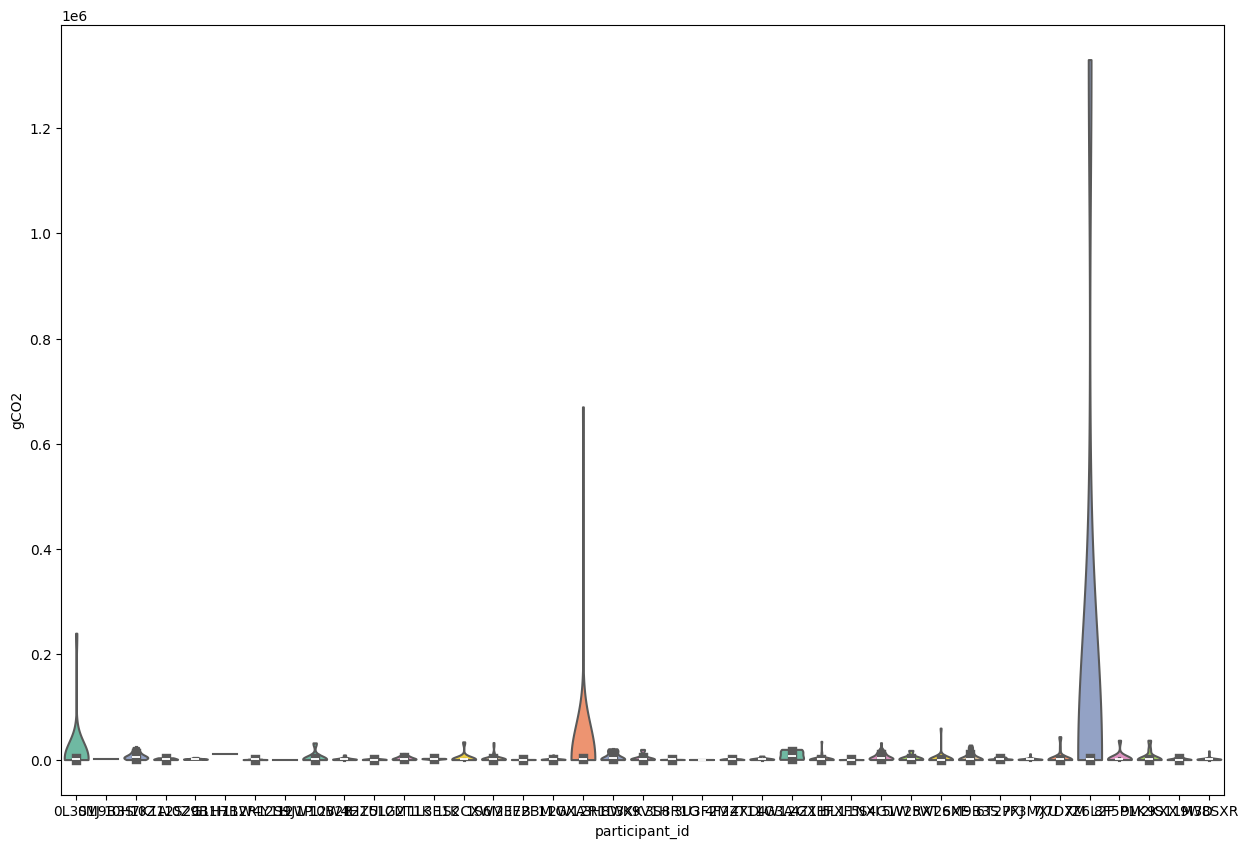

In [25]:
# Compute the emissions per day (using start time) for each person
df['start_time'] = pd.to_datetime(df['start_time'])
df['day'] = df['start_time'].dt.date
df_co2_per_day = df.groupby(['participant_id', 'day'])['gCO2'].sum()

# Plot emissions per day for each person in a violin plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='participant_id', y='gCO2', data=df_co2_per_day.reset_index(), inner='box', linewidth=1.5, saturation=0.8, width=0.8, cut=0, palette='Set2', hue='participant_id')
plt.show()

In [26]:
# Reduce precision of geohash by 1 character for the rows where we covered a long distance (more than 10 km)
df['start_geohash'] = df.apply(lambda x: x['start_geohash'][:-1] if x['distance(m)'] > 10000 else x['start_geohash'], axis=1)
df['end_geohash'] = df.apply(lambda x: x['end_geohash'][:-1] if x['distance(m)'] > 10000 else x['end_geohash'], axis=1)

In [27]:
# Define colors for each mode of transport
alpha = 128
colors = {
    'WALKING': [70, 130, 180, alpha],      # Steel Blue (distinct blue for walking)
    'ON_BICYCLE': [100, 149, 237, alpha],  # Cornflower Blue (different blue for bike)
    'ELECTRIC_BIKE': [100, 149, 237, alpha],
    'SCOOTER': [100, 149, 237, alpha],
    'TRAIN': [0, 191, 255, alpha],         # Deep Sky Blue (different blue for train)
    'BUS': [255, 182, 193, alpha],         # Light Pink (distinct from car/tram/plane)
    'ELECTRIC_BUS': [255, 182, 193, alpha],
    'COACH': [255, 182, 193, alpha],
    'CAR': [255, 105, 180, alpha],        # Hot Pink (distinct for car)
    'ELECTRIC_CAR': [255, 105, 180, alpha],
    'HYBRID_CAR': [255, 105, 180, alpha],
    'TRAM': [255, 160, 122, alpha],       # Light Salmon Pink (distinct from bus and car)
    'PLANE': [255, 105, 180, alpha],      # Hot Pink (same as car, but could be changed if needed)
    'BOAT': [255, 105, 180, alpha],       # Hot Pink
    'BOAT_NO_ENGINE': [255, 105, 180, alpha],
    'DETECTION_ERROR': [0, 0, 0, alpha],  # Black
}

In [28]:
df.size

60975

In [29]:
# IF two movements from the same user have the same start geohash and start time, we should merge them into a single movement (keep the one with the highest distance)
df['start_time'] = pd.to_datetime(df['start_time'])

# Group by participant_id, start_geohash, start_time and maximum distance, keep all the other data from the row with the maxium distance
df = df.groupby(['participant_id', 'start_geohash', 'start_time'])['distance(m)'].max().reset_index().merge(df, on=['participant_id', 'start_geohash', 'start_time', 'distance(m)'])

In [30]:
df.size

45075

In [40]:
# Merge consecutive movements with the same mode of transport
def merge_consecutive_movements(df, time_min):
    # Group movements by participant and mode of transport, and sort by start time
    df = df.sort_values(['participant_id', 'mean_of_transport', 'start_time_precise'])

    # Calculate time difference between end time of one movement and start time of the next
    df['prev_end_time'] = df.groupby(['participant_id', 'mean_of_transport'])['end_time_precise'].shift()
    df['time_diff'] = (df['start_time_precise'] - pd.to_datetime(df['prev_end_time'])).dt.total_seconds() / 60

    # Create a new column to store the group number
    df['group'] = (df['time_diff'] > time_min).cumsum()

    # Group by participant, mode of transport and group number, and calculate the start and end time of the group
    return df.groupby(['participant_id', 'mean_of_transport', 'group']).agg(
        start_time_precise=('start_time_precise', 'first'),
        end_time_precise=('end_time_precise', 'last'),
        start_geohash=('start_geohash', 'first'),
        end_geohash=('end_geohash', 'last'),
        distance=('distance', 'sum'),
        gCO2=('gCO2', 'sum')
    ).reset_index()

In [32]:
df = merge_consecutive_movements(df, 60)

In [33]:
# Get only the rows with distance smaller than 10km
'''
df_copy = df.copy()
df = df[df['distance(m)'] < 10000]
'''

"\ndf_copy = df.copy()\ndf = df[df['distance(m)'] < 10000]\n"

In [34]:
# Get only the rows with distance bigger than 10km

df = df_copy.copy()
df_copy = df.copy()
df = df[df['distance(m)'] > 10000]


NameError: name 'df_copy' is not defined

In [35]:
# Process all paths in one step
df['start_coords'] = df['start_geohash'].apply(geohash_to_coordinate)
df['end_coords'] = df['end_geohash'].apply(geohash_to_coordinate)

# Add slight offsets to avoid overlaps
df['start_coords'] = df['start_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])
df['end_coords'] = df['end_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])

'''
# Add random height to the start and end coordinates
df['start_coords'] = df['start_coords'].apply(lambda x: [x[0], x[1], random.randint(10000, 20000)])
df['end_coords'] = df['end_coords'].apply(lambda x: [x[0], x[1], random.randint(10000, 20000)])
'''

# Create data list for Pydeck
path_data = df[['start_coords', 'end_coords', 'mean_of_transport', 'participant_id']].copy()
path_data['color'] = path_data['mean_of_transport'].apply(lambda x: colors.get(x, [0, 0, 0])) # Default black for unknown transport
path_data['color_start'] = path_data['color'].apply(lambda x: [xi * 0.7 for xi in x])  # Slightly darker starting color

# Pydeck ArcLayer (Curved Lines)
layer = pdk.Layer(
    "ArcLayer",
    data=path_data,
    get_source_position="start_coords",
    get_target_position="end_coords",
    get_source_color="color_start",
    get_target_color="color",
    get_color="color", # for linelayer
    get_width=1,
    get_height = 1, # Change the height of the arc, negative values make it go down
    pickable=True,
    auto_highlight=True,
)

# Define map view
view_state = pdk.ViewState(
    latitude=df['start_coords'].iloc[0][1],  # Center on first start point
    longitude=df['start_coords'].iloc[0][0],
    zoom=8,
    pitch=80,  # Adds some 3D depth for better arc visibility
)

# Render and save
deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{participant_id} - {mean_of_transport}"})
deck.to_html("maps/paths_map_mot.html")

# Open in browser
!open -a Arc maps/paths_map_mot.html

In [36]:
# Group trips that were from the same start and end geohash and vehicle, to reduce clutter
grouped = df.groupby(['start_geohash', 'end_geohash', 'mean_of_transport']).size().reset_index(name='counts')

# Get coordinates from geohashes
grouped['start_coords'] = grouped['start_geohash'].apply(geohash_to_coordinate)
grouped['end_coords'] = grouped['end_geohash'].apply(geohash_to_coordinate)

# Add slight offsets to avoid overlaps
grouped['start_coords'] = grouped['start_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])
grouped['end_coords'] = grouped['end_coords'].apply(lambda x: [x[1] + (random.random() - 0.5) * 0.001, x[0] + (random.random() - 0.5) * 0.001])

# Create data list for Pydeck
path_data = grouped[['start_coords', 'end_coords', 'mean_of_transport', 'counts']].copy()
path_data['color'] = path_data['mean_of_transport'].apply(lambda x: colors.get(x, [0, 0, 0])) # Default black for unknown transport
path_data['color_start'] = path_data['color'].apply(lambda x: [xi * 0.7 for xi in x])  # Slightly darker starting color

# Get maxium count for scaling - then scale with a log scale, with minimum 1 width and maximum 5
max_count = path_data['counts'].max()
path_data['width'] = path_data['counts'].apply(lambda x: max(1, min(5, math.log(x + 1) / math.log(max_count + 1) * 5)))

# Pydeck ArcLayer (Curved Lines)
layer = pdk.Layer(
    "ArcLayer",
    data=path_data,
    get_source_position="start_coords",
    get_target_position="end_coords",
    get_source_color="color_start",
    get_target_color="color",
    get_width="width",  # Scale width based on counts
    pickable=True,
    auto_highlight=True,
)

# Define map view
view_state = pdk.ViewState(
    latitude=df['start_coords'].iloc[0][1],  # Center on first start point
    longitude=df['start_coords'].iloc[0][0],
    zoom=8,
    pitch=30,  # Adds some 3D depth for better arc visibility
)

# Render and  save
deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{mean_of_transport} - {counts}"})
deck.to_html("maps/paths_map_mot_grouped.html")

# Open in browser
!open -a Arc maps/paths_map_mot_grouped.html

In [72]:
# Print distances by train, average, median and standard deviation
train = df[df['mean_of_transport'] == 'TRAIN']['distance(m)']

print('Train distances:')
print('Average:', train.mean())
print('Median:', train.median())

print(train.describe())

print(train)

Train distances:
Average: 35832.89820359281
Median: 26769.0
count      1169.000000
mean      35832.898204
std       39685.264692
min         264.000000
25%        7643.000000
50%       26769.000000
75%       48681.000000
max      311709.000000
Name: distance(m), dtype: float64
0        49134
4        19710
8        20679
28       16209
97      109620
         ...  
6335     23989
6337     57321
6354     20223
6433     66371
6437     29339
Name: distance(m), Length: 1169, dtype: int64


# Create a Origin-Destination (OD) Matrix by city/village

In [41]:
# Merge consecutive movements with the same mode of transport
df = merge_consecutive_movements(df, 60)

In [42]:
df

,participant_id,mean_of_transport,group,start_time_precise,end_time_precise,start_geohash,end_geohash,distance,gCO2
0,0L3S1J,BOAT,0,2025-06-02 15:33:03,2025-06-02 16:26:20,u3buwr,u3buwp,8332,1341
1,0L3S1J,BOAT_NO_ENGINE,0,2025-05-26 12:44:12,2025-05-26 18:30:06,u0qj6,u0qj6,23118,0
2,0L3S1J,BUS,0,2025-05-23 15:38:13,2025-05-23 16:00:37,u0qd1,u0q98,10117,1335
3,0L3S1J,BUS,1,2025-05-24 10:49:10,2025-05-24 11:14:12,u0q98,u0qd1,10201,1346
4,0L3S1J,BUS,2,2025-06-09 05:21:16,2025-06-09 05:28:47,u0q5dt,u0q5e4,3939,519
...,...,...,...,...,...,...,...,...,...
2592,9W8SXR,WALKING,2377,2025-06-27 13:49:12,2025-06-27 13:55:47,u0qtv0,u0qtv1,291,0
2593,9W8SXR,WALKING,2378,2025-06-27 16:25:16,2025-06-27 16:56:44,u0qnnq,u0qnnq,355,0
2594,9W8SXR,WALKING,2379,2025-06-28 05:35:12,2025-06-28 05:42:06,u0qnnr,u0qnnq,261,0
2595,9W8SXR,WALKING,2380,2025-06-29 09:02:39,2025-06-29 09:40:54,u0qnnq,u0qnnx,1451,0


In [43]:
# Load swiss communes from geopackage
communes = gpd.read_file('data/AMTOVZ_SHP_LV95/AMTOVZ_LOCALITY.shp')

In [44]:
communes

,LOCALITYID,NAME,SHORTNAME,INDEXNAME,LANGUAGE,STATUS,INMODIFICA,VALIDITY,MODIFIED,SHAPE_AREA,SHAPE_LEN,geometry
0,036C7990-5F3C-47B6-B631-EBCE5C00B3D5,Sigigen,Sigigen,Sigigen,DE,REAL,FALSE,2008-07-01,2020-06-23,9.021343e+06,17294.388338,"POLYGON ((2652986.713 1211175.855, 2652957.958..."
1,9ACFF1C1-EFF4-470C-AC30-3DDED3D48848,Gündisau,Gündisau,Gündisau,DE,REAL,FALSE,2011-05-01,2021-01-26,3.480031e+06,9433.884983,"POLYGON ((2703275.389 1252023.596, 2703279.729..."
2,EA22EC8E-4896-4085-997A-75706EC8A610,Le Prese,Le Prese,Prese,IT,REAL,FALSE,2008-07-01,2021-02-10,2.594666e+07,28915.816357,"POLYGON ((2803556.980 1131931.774, 2803768.388..."
3,228A653B-E8CB-468A-A375-BE4E3A166CEE,Herrliberg,Herrliberg,Herrliberg,DE,REAL,FALSE,2008-07-01,2024-02-28,1.058630e+07,17747.466037,"POLYGON ((2686888.836 1238221.854, 2687715.974..."
4,B6CEDE71-D49A-43DD-BC52-63828DA520C9,Grandvaux,Grandvaux,Grandvaux,FR,REAL,FALSE,2008-07-01,2025-02-26,4.358285e+06,11265.114285,"POLYGON ((2545940.659 1151783.320, 2546166.816..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3968,3784162E-9161-4CE5-9E54-9617E0B7E486,Eschlikon TG,Eschlikon TG,Eschlikon,DE,REAL,FALSE,2008-07-01,2020-12-17,5.536997e+06,18698.286016,"POLYGON ((2715866.848 1256189.346, 2715862.844..."
3969,DEA40FE1-8242-40C5-9D4F-BE01B6AB9021,Wallenwil,Wallenwil,Wallenwil,DE,REAL,FALSE,2008-07-01,2020-12-17,1.845030e+06,8090.058716,"POLYGON ((2713835.829 1256301.692, 2713838.530..."
3970,C854C132-8521-4D48-86A2-50C79AD4938A,Herrenhof,Herrenhof,Herrenhof,DE,REAL,FALSE,2008-07-01,2023-07-20,1.660492e+06,6942.976749,"POLYGON ((2736605.705 1273013.588, 2736474.571..."
3971,69F84791-0065-42D5-8CA8-3CBBA0D92EA7,Dällikon,Dällikon,Dällikon,DE,REAL,FALSE,2008-07-01,2017-08-21,4.506356e+06,9645.669488,"POLYGON ((2673890.596 1254172.412, 2673869.182..."


In [45]:
# Convert LV95 to WGS84
communes = communes.to_crs(epsg=4326)

communes

,LOCALITYID,NAME,SHORTNAME,INDEXNAME,LANGUAGE,STATUS,INMODIFICA,VALIDITY,MODIFIED,SHAPE_AREA,SHAPE_LEN,geometry
0,036C7990-5F3C-47B6-B631-EBCE5C00B3D5,Sigigen,Sigigen,Sigigen,DE,REAL,FALSE,2008-07-01,2020-06-23,9.021343e+06,17294.388338,"POLYGON ((8.13596 47.04950, 8.13558 47.04959, ..."
1,9ACFF1C1-EFF4-470C-AC30-3DDED3D48848,Gündisau,Gündisau,Gündisau,DE,REAL,FALSE,2011-05-01,2021-01-26,3.480031e+06,9433.884983,"POLYGON ((8.80705 47.41092, 8.80711 47.41088, ..."
2,EA22EC8E-4896-4085-997A-75706EC8A610,Le Prese,Le Prese,Prese,IT,REAL,FALSE,2008-07-01,2021-02-10,2.594666e+07,28915.816357,"POLYGON ((10.08145 46.30793, 10.08420 46.30809..."
3,228A653B-E8CB-468A-A375-BE4E3A166CEE,Herrliberg,Herrliberg,Herrliberg,DE,REAL,FALSE,2008-07-01,2024-02-28,1.058630e+07,17747.466037,"POLYGON ((8.58728 47.28917, 8.59832 47.29387, ..."
4,B6CEDE71-D49A-43DD-BC52-63828DA520C9,Grandvaux,Grandvaux,Grandvaux,FR,REAL,FALSE,2008-07-01,2025-02-26,4.358285e+06,11265.114285,"POLYGON ((6.73422 46.51516, 6.73719 46.51329, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3968,3784162E-9161-4CE5-9E54-9617E0B7E486,Eschlikon TG,Eschlikon TG,Eschlikon,DE,REAL,FALSE,2008-07-01,2020-12-17,5.536997e+06,18698.286016,"POLYGON ((8.97493 47.44629, 8.97488 47.44629, ..."
3969,DEA40FE1-8242-40C5-9D4F-BE01B6AB9021,Wallenwil,Wallenwil,Wallenwil,DE,REAL,FALSE,2008-07-01,2020-12-17,1.845030e+06,8090.058716,"POLYGON ((8.94804 47.44765, 8.94807 47.44769, ..."
3970,C854C132-8521-4D48-86A2-50C79AD4938A,Herrenhof,Herrenhof,Herrenhof,DE,REAL,FALSE,2008-07-01,2023-07-20,1.660492e+06,6942.976749,"POLYGON ((9.25499 47.59358, 9.25328 47.59476, ..."
3971,69F84791-0065-42D5-8CA8-3CBBA0D92EA7,Dällikon,Dällikon,Dällikon,DE,REAL,FALSE,2008-07-01,2017-08-21,4.506356e+06,9645.669488,"POLYGON ((8.41810 47.43420, 8.41782 47.43428, ..."


In [46]:
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import geohash2
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="geo_mapping")

# Function to get city from geohash
def geohash_to_city(lat, lon):
    for i in range(1, 5):
        try:
            location = geolocator.reverse((lat, lon), exactly_one=True, language='en')
            if location and "city" in location.raw["address"]:
                return location.raw["address"]["city"]
            elif location and "town" in location.raw["address"]:
                return location.raw["address"]["town"]
            elif location and "village" in location.raw["address"]:
                return location.raw["address"]["village"]
            return "Unknown"
        except:
            # Sleep 1s and try again
            time.sleep(1)
            continue
    return "Unknown"

# For a geohash, get the commune it is in
def geohash_to_commune(geohash):
    try:
        lat, lon = geolib.decode(geohash)
        point = gpd.GeoSeries([Point(lon, lat)])
        commune = communes[communes.contains(point.unary_union)].iloc[0]['NAME']
        return commune
    except Exception as e:
        return "Abroad"
        # If it didn't work, it is not in switzerland, so we want to find this using Nominatim
        #return geohash_to_city(lat, lon)

In [47]:
from tqdm import tqdm

geo_to_munic = {}

# Get all the geohashes in the dataframe
geohashes = pd.concat([df['start_geohash'], df['end_geohash']]).unique()

# Get the commune for each geohash
for geohash in tqdm(geohashes):
    geo_to_munic[geohash] = geohash_to_commune(geohash)

100%|██████████| 814/814 [00:01<00:00, 791.35it/s]


In [48]:
# Add commune to the dataframe by getting from the dictionary
df['start_commune'] = df['start_geohash'].map(geo_to_munic)
df['end_commune'] = df['end_geohash'].map(geo_to_munic)

In [49]:
# Calculate travel duration (in seconds)
df["travel_time"] = (df["end_time_precise"] - df["start_time_precise"]).dt.total_seconds()

# Remove rows with a travel time that is slower than 1 km/h
df = df[df["travel_time"] < df["distance"] * 3.6]

# Group by OD pairs
od_matrix = df.groupby(["start_commune", "end_commune"]).agg(
    count=("participant_id", "count"),
    avg_time=("travel_time", "mean"),
    min_time=("travel_time", "min"),
    max_time=("travel_time", "max")
).reset_index()

In [50]:
od_matrix

,start_commune,end_commune,count,avg_time,min_time,max_time
0,Aarau,Aarau Rohr,1,503.000000,503.0,503.0
1,Aarau,Winterthur,1,3812.000000,3812.0,3812.0
2,Aarau,Zürich,1,1863.000000,1863.0,1863.0
3,Aarau Rohr,Aarau,1,544.000000,544.0,544.0
4,Abroad,Abroad,107,2663.747664,19.0,39345.0
...,...,...,...,...,...,...
548,Zürich,Küsnacht ZH,2,3072.000000,2202.0,3942.0
549,Zürich,Uzwil,1,2486.000000,2486.0,2486.0
550,Zürich,Wil SG,1,4269.000000,4269.0,4269.0
551,Zürich,Winterthur,80,2150.287500,184.0,10577.0


In [51]:
# Get the list of cities that appear in rows with at least 20 counts
counts = od_matrix[od_matrix["count"] >= 20]
cities = list(set(counts["start_commune"]) | set(counts["end_commune"]))
cities

['Volketswil', 'Zürich', 'Abroad', 'Winterthur']

In [52]:
# Filter the OD matrix to only include the cities in the list
od_matrix_new = od_matrix[od_matrix["start_commune"].isin(cities) & od_matrix["end_commune"].isin(cities)]

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_51663/2807188529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_matrix_new.loc[:, "log_count"] = np.log(od_matrix_new["count"] + 1)


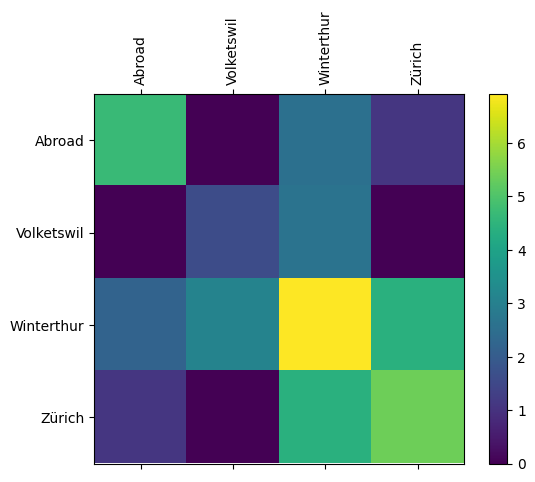

In [53]:
# Show heatmap of movements
od_matrix_new.loc[:, "log_count"] = np.log(od_matrix_new["count"] + 1)

# Get the list of cities
cities = sorted(cities)

# Create a matrix with the number of trips between each pair of cities
matrix = np.zeros((len(cities), len(cities)))

# Fill the matrix with the number of trips
for index, row in od_matrix_new.iterrows():
    start = cities.index(row["start_commune"])
    end = cities.index(row["end_commune"])
    matrix[start, end] = row["log_count"]

# Plot the matrix
fig, ax = plt.subplots()
mat = ax.matshow(matrix, cmap="viridis")
fig.colorbar(mat)
ax.set_xticks(range(len(cities)))
ax.set_xticklabels(cities, rotation=90)
ax.set_yticks(range(len(cities)))
ax.set_yticklabels(cities)
plt.show()

In [54]:
# Remove data with abroad communes from od_matrix_new
od_matrix_new = od_matrix_new[od_matrix_new["start_commune"] != "Abroad"]
od_matrix_new = od_matrix_new[od_matrix_new["end_commune"] != "Abroad"]

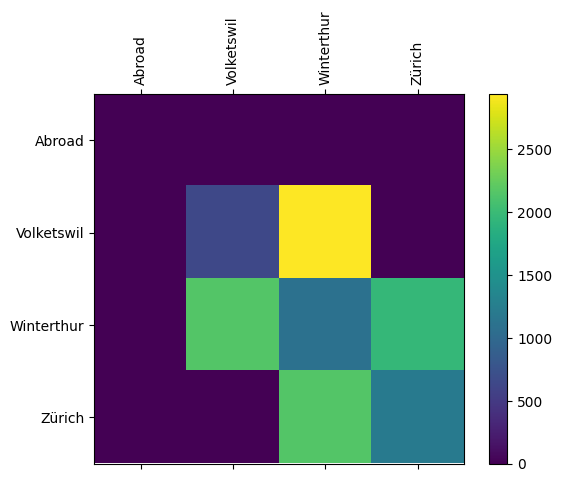

In [55]:
# Create a matrix with the average travel time between each pair of cities
matrix_time = np.zeros((len(cities), len(cities)))

# Fill the matrix with the average travel time
for index, row in od_matrix_new.iterrows():
    start = cities.index(row["start_commune"])
    end = cities.index(row["end_commune"])
    matrix_time[start, end] = row["avg_time"]

# Plot the matrix
fig, ax = plt.subplots()
mat = ax.matshow(matrix_time, cmap="viridis")
fig.colorbar(mat)
ax.set_xticks(range(len(cities)))
ax.set_xticklabels(cities, rotation=90)
ax.set_yticks(range(len(cities)))
ax.set_yticklabels(cities)
plt.show()

In [56]:
# Remove travels from a place to the same place
od_matrix_new = od_matrix_new[od_matrix_new["start_commune"] != od_matrix_new["end_commune"]]
od_matrix_new

,start_commune,end_commune,count,avg_time,min_time,max_time,log_count
403,Volketswil,Winterthur,13,2937.769231,1163.0,13226.0,2.639057
520,Winterthur,Volketswil,21,2146.619048,129.0,8859.0,3.091042
530,Winterthur,Zürich,79,1954.531646,644.0,8573.0,4.382027
551,Zürich,Winterthur,80,2150.287500,184.0,10577.0,4.394449


In [57]:
od_matrix_new.shape

(4, 7)

In [58]:
# Create temporary dataframe with the start and end communes swapped
'''
od_matrix_swapped = od_matrix_new.copy()
od_matrix_swapped["start_commune"] = od_matrix_new["end_commune"]
od_matrix_swapped["end_commune"] = od_matrix_new["start_commune"]

# Merge the two dataframes
od_matrix_merged = pd.concat([od_matrix_new, od_matrix_swapped])

# Group by OD pairs
od_matrix_grouped = od_matrix_merged.groupby(["start_commune", "end_commune"]).agg(
    count=("count", "sum"),
    avg_time=("avg_time", "mean"),
    min_time=("min_time", "min"),
    max_time=("max_time", "max")
).reset_index()

# Keep only the first row for each pair of communes
od_matrix_grouped = od_matrix_grouped.sort_values("count", ascending=False).drop_duplicates(["start_commune", "end_commune"])
'''

'\nod_matrix_swapped = od_matrix_new.copy()\nod_matrix_swapped["start_commune"] = od_matrix_new["end_commune"]\nod_matrix_swapped["end_commune"] = od_matrix_new["start_commune"]\n\n# Merge the two dataframes\nod_matrix_merged = pd.concat([od_matrix_new, od_matrix_swapped])\n\n# Group by OD pairs\nod_matrix_grouped = od_matrix_merged.groupby(["start_commune", "end_commune"]).agg(\n    count=("count", "sum"),\n    avg_time=("avg_time", "mean"),\n    min_time=("min_time", "min"),\n    max_time=("max_time", "max")\n).reset_index()\n\n# Keep only the first row for each pair of communes\nod_matrix_grouped = od_matrix_grouped.sort_values("count", ascending=False).drop_duplicates(["start_commune", "end_commune"])\n'

In [59]:
# Keep only cities that appear in rows with at least 20 counts
counts = od_matrix_new[od_matrix_new["count"] >= 30]
cities = list(set(counts["start_commune"]) | set(counts["end_commune"]))
cities

# Filter the OD matrix to only include the cities in the list
od_matrix_new = od_matrix_new[od_matrix_new["start_commune"].isin(cities) & od_matrix_new["end_commune"].isin(cities)]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
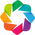

:Chord   [source,target]   (value)

In [60]:
import pandas as pd
import numpy as np
import holoviews as hv
from holoviews import dim

hv.extension('bokeh')

# Create a list of cities
cities = sorted(set(od_matrix_new["start_commune"]).union(set(od_matrix_new["end_commune"])))

# Create a DataFrame for links
links = [
    (row["start_commune"], row["end_commune"], row["count"])
    for _, row in od_matrix_new.iterrows()
]

# Convert to HoloViews DataFrame
chord = hv.Chord(pd.DataFrame(links, columns=["source", "target", "value"]))

# Styling with different color for each source
chord.opts(
    cmap='Category20', edge_color=dim('source').str(), 
    node_color=dim('index').str(), labels='index', width=800, height=800
)
chord

/var/folders/0v/mryc8sr57kb1272k8bhj0z083fl3sj/T/ipykernel_51663/2016627770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date'] = df['start_time_precise'].dt.date


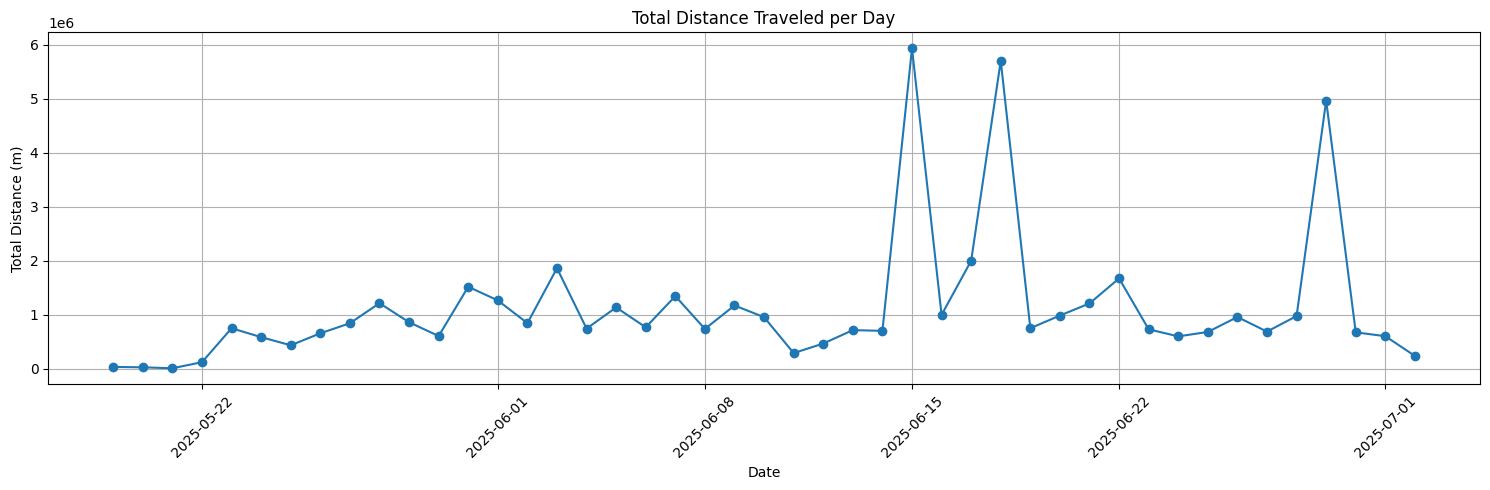

In [61]:
# Plot total number of kilometers per day
df['start_date'] = df['start_time_precise'].dt.date

# Group by start date and sum the distance
daily_distance = df.groupby('start_date')['distance'].sum().reset_index()
plt.figure(figsize=(15, 5))
plt.plot(daily_distance['start_date'], daily_distance['distance'], marker='o')
plt.title('Total Distance Traveled per Day')
plt.xlabel('Date')
plt.ylabel('Total Distance (m)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

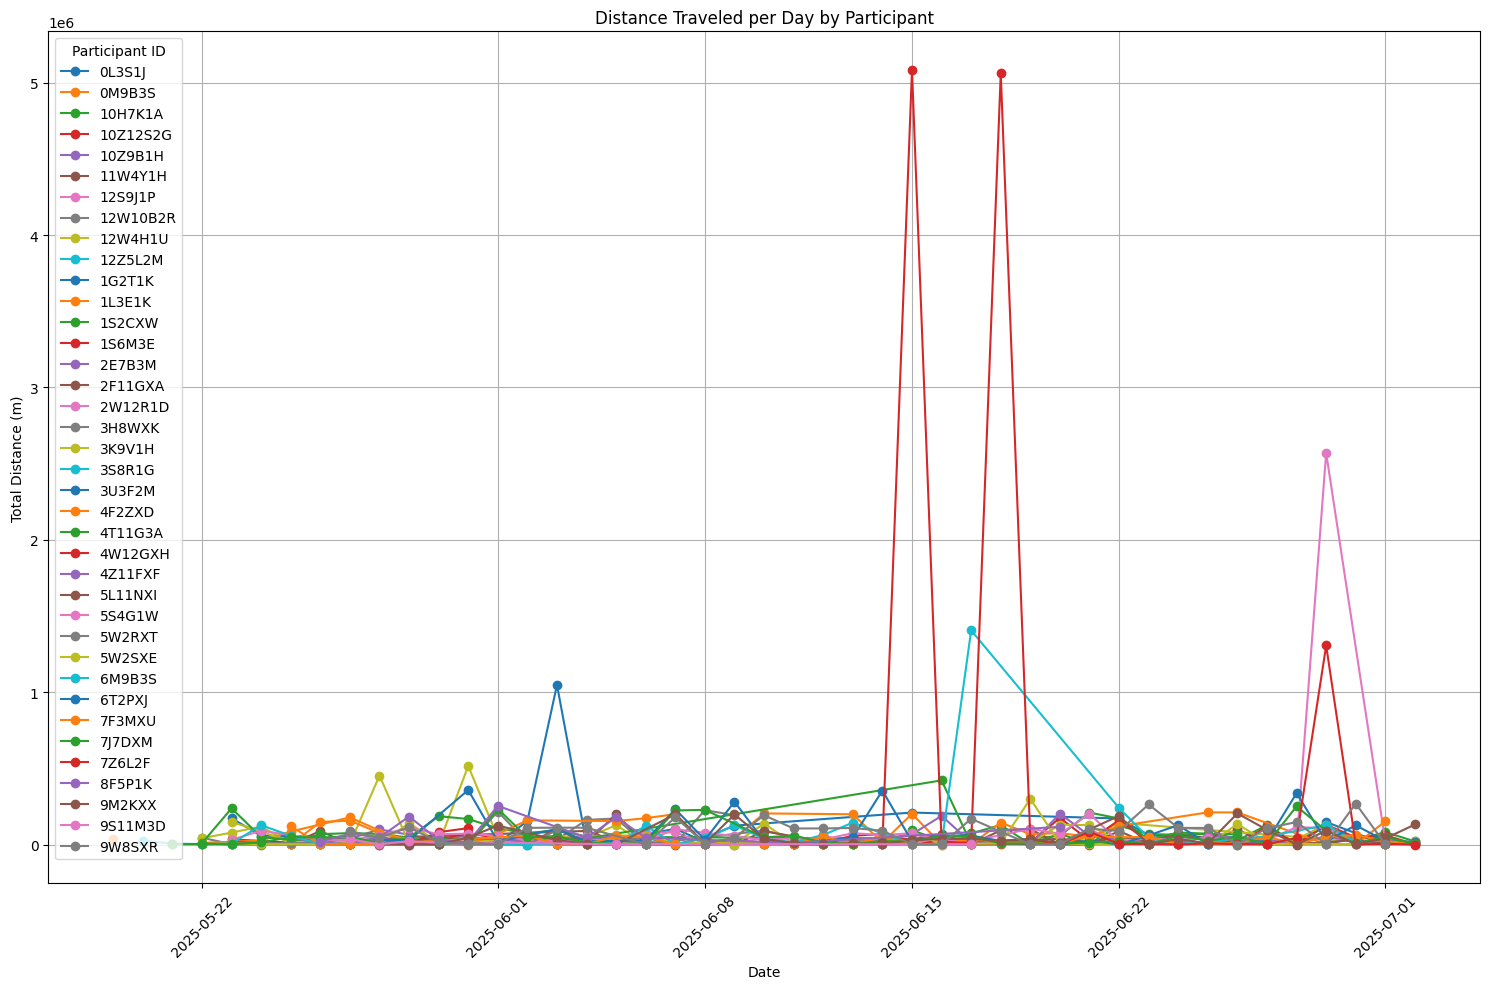

In [64]:
# Plot distance per day per each participant
plt.figure(figsize=(15, 10))
for participant in df['participant_id'].unique():
    participant_data = df[df['participant_id'] == participant]
    daily_distance = participant_data.groupby('start_date')['distance'].sum().reset_index()
    plt.plot(daily_distance['start_date'], daily_distance['distance'], marker='o', label=participant)   
plt.title('Distance Traveled per Day by Participant')
plt.xlabel('Date')
plt.ylabel('Total Distance (m)')
plt.xticks(rotation=45)
plt.legend(title='Participant ID')
plt.grid()
plt.tight_layout()
plt.show()